This notebook will implement changing lora settings and separate dataloader

In [1]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [2]:
# try with UMAP

In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
# from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
# from transformers import ESMTokenizer, ESMForSequenceClassification
import esm

from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  2.2.2
Transformers version:  4.35.2
Datasets version:  2.19.1


In [2]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/train_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
1,sp|P05787|K2C8_HUMAN%58%74,SGMGGITAVTVNQSLLSPLVLEVDPNIQAVRTQ,1
2,sp|Q14832|GRM3_HUMAN%829%845,QPQKNVVTHRLHLNRFSVSGTGTTYSQSSASTY,1
3,sp|P01106|MYC_HUMAN%46%62,SEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVT,1
4,sp|Q92736|RYR2_HUMAN%2792%2808,TREGDSMALYNRTRRISQTSQVSVDAAHGYSPR,1


In [6]:
# # Function to get the middle character
# def get_middle_char(sequence):
#     chars = list(sequence)
#     middle_index = len(chars) // 2
#     return chars[middle_index]

# # Apply the function to get the middle characters
# df['middle_char'] = df['sequence'].apply(get_middle_char)

In [7]:
# # Function to count 'S', 'T', 'Y' in a sequence
# def count_chars(sequence, char):
#     return sequence.count(char)

# # Count the occurrences of 'S', 'T', and 'Y' in the sequences
# df['count_S'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'S'))
# df['count_T'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'T'))
# df['count_Y'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'Y'))

# # Sum the counts to get the total occurrences in the DataFrame
# total_S = df['count_S'].sum()
# total_T = df['count_T'].sum()
# total_Y = df['count_Y'].sum()

# print(f"Total number of 'S': {total_S}")
# print(f"Total number of 'T': {total_T}")
# print(f"Total number of 'Y': {total_Y}")

In [8]:
# # Group by label and sum the counts
# grouped_counts = df.groupby('label')[['count_S', 'count_T', 'count_Y']].sum().reset_index()

# # Display the grouped counts
# print(grouped_counts)

In [9]:
# # Separate the DataFrame by middle character
# df_S = df[df['middle_char'] == 'S']
# df_T = df[df['middle_char'] == 'T']
# df_Y = df[df['middle_char'] == 'Y']

# # Separate each subset by label
# df_S_0 = df_S[df_S['label'] == 0]
# df_S_1 = df_S[df_S['label'] == 1]
# df_T_0 = df_T[df_T['label'] == 0]
# df_T_1 = df_T[df_T['label'] == 1]
# df_Y_0 = df_Y[df_Y['label'] == 0]
# df_Y_1 = df_Y[df_Y['label'] == 1]


In [10]:
# from sklearn.utils import resample
# # Desired number of samples per group
# n_samples_S = 500
# n_sampple_T = 300
# n_sampple_Y = 200
# # Perform stratified sampling
# df_S_0_resampled = resample(df_S_0, replace=False, n_samples=n_samples_S, random_state=42)
# df_S_1_resampled = resample(df_S_1, replace=False, n_samples=n_samples_S, random_state=42)
# df_T_0_resampled = resample(df_T_0, replace=True, n_samples=n_sampple_T, random_state=42)
# df_T_1_resampled = resample(df_T_1, replace=True, n_samples=n_sampple_T, random_state=42)
# df_Y_0_resampled = resample(df_Y_0, replace=True, n_samples=n_sampple_Y, random_state=42)
# df_Y_1_resampled = resample(df_Y_1, replace=True, n_samples=n_sampple_Y, random_state=42)



In [11]:
# # Combine the resampled subsets
# balanced_df = pd.concat([
#     df_S_0_resampled, df_S_1_resampled,
#     df_T_0_resampled, df_T_1_resampled,
#     df_Y_0_resampled, df_Y_1_resampled
# ])

# # Shuffle the combined DataFrame
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Balanced DataFrame:")
# print(balanced_df)


In [12]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into training and validation sets
# my_train, my_valid = train_test_split(
#     balanced_df, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=balanced_df[['label', 'middle_char']]
# )

# my_train=my_train[["sequence", "label"]]
# my_valid=my_valid[["sequence","label"]]


# # Print the first 5 rows of the training set
# print("Training Set:")
# print(my_train.shape)

# # Print the first 5 rows of the validation set
# print("\nValidation Set:")
# print(my_valid.shape)

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(1584, 2)

Validation Set:
(396, 2)


In [5]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self, lora_rank=4, lora_init_scale=0.01, lora_scaling_rank=1):
        self.lora_rank = lora_rank
        self.lora_init_scale = lora_init_scale
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = lora_scaling_rank
        # lora_modules and lora_layers are specified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [7]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
        
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits

    # def forward(self, hidden_states):

    #     hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.dense(hidden_states)
    #     hidden_states = torch.tanh(hidden_states)
    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.out_proj(hidden_states)
    #     return hidden_states
    
    # def forward(self, hidden_states):
    #     # Original sequence length and middle index
    #     seq_length = hidden_states.size(1)
    #     middle_idx = seq_length // 2

    #     # Extract the middle embedding vector
    #     middle_embedding = hidden_states[:, middle_idx, :]

    #     # Amplify the influence of the middle embedding
    #     amplified_middle_embedding = middle_embedding * 2

    #     # Combine with average to retain context
    #     average_embedding = torch.mean(hidden_states, dim=1)
    #     combined_embedding = 0.5 * amplified_middle_embedding + 0.5 * average_embedding

    #     # Classification layers
    #     x = self.dropout(combined_embedding)
    #     x = self.dense(x)
    #     x = torch.tanh(x)
    #     x = self.dropout(x)
    #     logits = self.out_proj(x)
    #     return logits


# class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

#     def __init__(self, config: T5Config, class_config):
#         super().__init__(config)
#         self.num_labels = class_config.num_labels
#         self.config = config

#         self.shared = nn.Embedding(config.vocab_size, config.d_model)

#         encoder_config = copy.deepcopy(config)
#         encoder_config.use_cache = False
#         encoder_config.is_encoder_decoder = False
#         self.encoder = T5Stack(encoder_config, self.shared)

#         self.dropout = nn.Dropout(class_config.dropout_rate) 
#         self.classifier = T5EncoderClassificationHead(config, class_config)

#         # Initialize weights and apply final processing
#         self.post_init()

#         # Model parallel
#         self.model_parallel = False
#         self.device_map = None

#     def parallelize(self, device_map=None):
#         self.device_map = (
#             get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
#             if device_map is None
#             else device_map
#         )
#         assert_device_map(self.device_map, len(self.encoder.block))
#         self.encoder.parallelize(self.device_map)
#         self.classifier = self.classifier.to(self.encoder.first_device)
#         self.model_parallel = True

#     def deparallelize(self):
#         self.encoder.deparallelize()
#         self.encoder = self.encoder.to("cpu")
#         self.model_parallel = False
#         self.device_map = None
#         torch.cuda.empty_cache()

#     def get_input_embeddings(self):
#         return self.shared

#     def set_input_embeddings(self, new_embeddings):
#         self.shared = new_embeddings
#         self.encoder.set_input_embeddings(new_embeddings)

#     def get_encoder(self):
#         return self.encoder

#     def _prune_heads(self, heads_to_prune):
#         """
#         Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
#         class PreTrainedModel
#         """
#         for layer, heads in heads_to_prune.items():
#             self.encoder.layer[layer].attention.prune_heads(heads)

#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         head_mask=None,
#         inputs_embeds=None,
#         labels=None,
#         output_attentions=None,
#         output_hidden_states=None,
#         return_dict=None,
#     ):
#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

#         outputs = self.encoder(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             inputs_embeds=inputs_embeds,
#             head_mask=head_mask,
#             output_attentions=output_attentions,
#             output_hidden_states=True,
#             return_dict=return_dict,
#         )

#         hidden_states = outputs[0]
#         logits = self.classifier(hidden_states)

#         loss = None
#         if labels is not None:
#             if self.config.problem_type is None:
#                 if self.num_labels == 1:
#                     self.config.problem_type = "regression"
#                 elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
#                     self.config.problem_type = "single_label_classification"
#                 else:
#                     self.config.problem_type = "multi_label_classification"

#             if self.config.problem_type == "regression":
#                 loss_fct = MSELoss()
#                 if self.num_labels == 1:
#                     loss = loss_fct(logits.squeeze(), labels.squeeze())
#                 else:
#                     loss = loss_fct(logits, labels)
#             elif self.config.problem_type == "single_label_classification":
#                 loss_fct = CrossEntropyLoss()
#                 loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#             elif self.config.problem_type == "multi_label_classification":
#                 loss_fct = BCEWithLogitsLoss()
#                 loss = loss_fct(logits, labels)
#         if not return_dict:
#             output = (logits,) + outputs[1:]
#             return ((loss,) + output) if loss is not None else output

#         return SequenceClassifierOutput(
#             loss=loss,
#             logits=logits,
#             hidden_states=outputs.hidden_states,
#             attentions=outputs.attentions,
#         )
        
# import esm
import torch
import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput

class ESMEncoderForSimpleSequenceClassification(nn.Module):
    def __init__(self, esm_model, class_config):
        super().__init__()
        self.esm_model = esm_model
        self.num_labels = class_config.num_labels
        self.dropout = nn.Dropout(class_config.dropout_rate)
        
        # Get the dimension of the embeddings
        embed_dim = esm_model.args.embed_dim
        self.classifier = nn.Linear(embed_dim, class_config.num_labels)

        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get the hidden states from the ESM model
        outputs = self.esm_model(input_ids, repr_layers=[33])
        hidden_states = outputs["representations"][33]

        # Emphasize the middle token representation
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.squeeze(), labels.squeeze())
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=hidden_states,
            attentions=None,
        )



# # Load ESM model
# esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

# # Initialize class configuration
# class_config = ClassConfig(dropout=0.7, num_labels=2)

# # Initialize the model with ESM encoder
# model = ESMEncoderForSimpleSequenceClassification(esm_model, class_config)


In [8]:
# def PT5_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
#     # Load PT5 and tokenizer
#     model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
#     tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False, force_download=True) 
    
#     # Create new Classifier model with PT5 dimensions
#     class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
#     class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
#     # Set encoder and embedding weights to checkpoint weights
#     class_model.shared=model.shared
#     class_model.encoder=model.encoder    
    
#     # Delete the checkpoint model
#     model=class_model
#     del class_model
    
#     # Print number of trainable parameters
#     model_parameters = filter(lambda p: p.requires_grad, model.parameters())
#     params = sum([np.prod(p.size()) for p in model_parameters])
#     print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
#     # Add model modification lora
#     config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
#     # Add LoRA layers
#     model = modify_with_lora(model, config)
    
#     # Freeze Embeddings and Encoder (except LoRA)
#     for (param_name, param) in model.shared.named_parameters():
#                 param.requires_grad = False
#     for (param_name, param) in model.encoder.named_parameters():
#                 param.requires_grad = False       

#     for (param_name, param) in model.named_parameters():
#             if re.fullmatch(config.trainable_param_names, param_name):
#                 param.requires_grad = True

#     # Print trainable Parameter          
#     model_parameters = filter(lambda p: p.requires_grad, model.parameters())
#     params = sum([np.prod(p.size()) for p in model_parameters])
#     print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
#     return model, tokenizer

# import esm
def ESM_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
    # Load ESM model and alphabet
    # esm2_t33_650M_UR50D
    esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    batch_converter = alphabet.get_batch_converter()
    
    # Define class configuration
    class_config = ClassConfig(num_labels=num_labels, dropout=dropout)
    
    # Create new classifier model with ESM dimensions
    class_model = ESMEncoderForSimpleSequenceClassification(esm_model, class_config)
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, class_model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_Classfier\nTrainable Parameter: " + str(params))
    
    # Add model modification LoRA
    config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
    # Add LoRA layers
    class_model = modify_with_lora(class_model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for param_name, param in class_model.esm_model.named_parameters():
        param.requires_grad = False

    for param_name, param in class_model.named_parameters():
        if re.fullmatch(config.trainable_param_names, param_name):
            param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, class_model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_LoRA_Classfier\nTrainable Parameter: " + str(params) + "\n")
    
    return class_model, batch_converter



In [9]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [10]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [10]:
# os.environ['HF_HOME'] = '/home/ubuntu/data/hai/huggingface_cache'

In [11]:
# from sklearn.metrics import accuracy_score
# #!pip install seaborn
# import seaborn as sns
# import gc

# # Set random seeds for reproducibility of your trainings run
# def set_seeds(s):
#     torch.manual_seed(s)
#     np.random.seed(s)
#     random.seed(s)
#     set_seed(s)

# def apply_umap(embeddings, n_components=2, min_dist=0.01):
#     umap_model = umap.UMAP(n_components=n_components)
#     umap_embeddings = umap_model.fit_transform(embeddings)
#     return umap_embeddings

# def plot_umap(embeddings, labels):
#     data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
#     df = pd.DataFrame(data)
    
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
#     plt.title("UMAP Visualization of Embeddings")
#     plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
#     plt.show()
    
# # Main training fuction
# def train_per_protein(
#         train_dataset,         #training data
#         valid_dataset,         #validation data      
#         weight_decay,
#         warmup_pct,
#         num_labels= 2,    #1 for regression, >1 for classification
    
#         # effective training batch size is batch * accum
#         # we recommend an effective batch size of 8 
#         batch= 4,         #for training
#         accum= 2,         #gradient accumulation
    
#         val_batch = 16,   #batch size for evaluation
#         epochs=1,       #training epochs
#         lr= 3e-4,         #recommended learning rate
#         seed= 42,         #random seed
#         deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
#         gpu= 1,
#         dropout=0.5, #dropout rate
#          #L2 weight regularization
#         lora_rank=4,      #lora rank
#         lora_init_scale=0.01, #lora scaling rank
#         lora_scaling_rank=1,       #lora a
#         ):         #gpu selection (1 for first gpu)

#     # Set gpu device
#     os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
#     # Set all random seeds
#     set_seeds(seed)
    
#     # load model
#     model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)

#     # Huggingface Trainer arguments
#     total_steps = epochs * len(train_dataset) // batch
#     warmup_steps = int(warmup_pct * total_steps)
     
#     # Define TrainingArguments
#     args = TrainingArguments(
#         output_dir='./results',              # where to save the model
#         evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
#         logging_strategy='epoch',
#         save_strategy='no',
#         learning_rate=lr,                    # initial learning rate
#         per_device_train_batch_size=batch,   # batch size per device
#         gradient_accumulation_steps=accum,   # gradient accumulation steps
#         num_train_epochs=epochs,             # number of epochs to train
#         weight_decay=weight_decay,           # L2 weight regularization
#         warmup_steps=warmup_steps,           # 10% of total steps
#         load_best_model_at_end=False,         # load the best model at the end of training
#         seed=seed,                           # random seed
#         push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
#         logging_dir='./logs',
#     )
#     # metric_for_best_model='eval_loss|accuracy'

#     # Metric definition for validation data
#     def compute_metrics(eval_pred):
#         predictions, labels = eval_pred.predictions, eval_pred.label_ids
#         # Check if predictions have the expected shape
#         if isinstance(predictions, tuple):
#             predictions = predictions[0]
#         if predictions.ndim > 1 and predictions.shape[1] > 1:
#             predictions = np.argmax(predictions, axis=1)
#         # Now, compute the metric (e.g., accuracy)
#         accuracy = accuracy_score(labels, predictions)
        
#         # Return the metric(s) as a dictionary
#         return {"accuracy": accuracy}
    
#     # For minimizing loss
#     early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

#     # For maximizing accuracy
#     early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
#     # Trainer          
#     trainer = Trainer(
#         model,
#         args,
#         train_dataset=train_dataset,
#         eval_dataset=valid_dataset,
#         tokenizer=tokenizer,
#         compute_metrics=compute_metrics,
#         callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
#             early_stopping_patience=3,
#             min_delta=0.001,
#             output_dir='./model_output',
#             filename='finetuned_model_all_bfd.pth'
#         )],
#     )    

#     def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
#         embeddings = []
#         model = model.to(device)
#         model.eval()
    
#         # Iterate over the sequences in batches
#         for i in range(0, len(sequences), batch_size):
#             # Extract a batch of sequences
#             batch = sequences[i:i + batch_size]
    
#             # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
#             inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
#             with torch.no_grad():
#                 # Forward pass through the model to obtain outputs
#                 outputs = model(**inputs)
    
#             # Extract hidden states from the second-to-last layer (penultimate layer)
#             hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
#             # Take the embeddings from the second-to-last layer
#             embeddings_from_layer = hidden_states[:, 0, :]
    
#             # Extend the list with the generated embeddings
#             embeddings.extend(embeddings_from_layer)
    
#             print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
#         return np.array(embeddings)

        
#     # Train model
#     trainer.train()

#     # Get the best model
#     # model = trainer.model
#     # Ensure the best model is loaded
#     best_model_path = os.path.join('./model_output', 'finetuned_model_all_bfd.pth')
#     if os.path.exists(best_model_path):
#         state_dict = torch.load(best_model_path)
#         model.load_state_dict(state_dict, strict=False)
#         print(f"Loaded best model from {best_model_path}")
        
#     # Evaluate the best model
#     eval_results = trainer.evaluate()
#     print(eval_results)
    
#     # Print the current learning rate
#     # current_lr = trainer.optimizer.param_groups[0]['lr']
#     # print(f"Current learning rate: {current_lr}")
    
#     # valid_sequences = list(valid_dataset['sequence'])
#     # valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

#     # # Apply UMAP for dimensionality reduction
#     # umap_embeddings = apply_umap(valid_embeddings)

#     # # Plot UMAP embeddings
#     # labels = list(valid_dataset['label'])
#     # plot_umap(umap_embeddings, labels)
    
#     torch.cuda.empty_cache()
#     gc.collect()

#     return tokenizer, model, trainer.state.log_history


In [11]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import gc
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer, set_seed
from transformers.trainer_callback import EarlyStoppingCallback

def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()

# Main training function
def train_per_protein(
        train_dataset,         # training data
        valid_dataset,         # validation data
        weight_decay,
        warmup_pct,
        num_labels=2,    # 1 for regression, >1 for classification
        batch=4,         # for training
        accum=2,         # gradient accumulation
        val_batch=16,   # batch size for evaluation
        epochs=1,       # training epochs
        lr=3e-4,         # recommended learning rate
        seed=42,         # random seed
        deepspeed=False,  # if GPU is large enough, disable deepspeed for training speedup
        gpu=1,
        dropout=0.5,     # dropout rate
        lora_rank=4,     # LoRA rank
        lora_init_scale=0.01, # LoRA scaling rank
        lora_scaling_rank=1,  # LoRA a
        ):
    
    # Set GPU device
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # Load model
    model, batch_converter = ESM_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_dataset) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,        # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    # early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # # For maximizing accuracy
    # early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)

    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=None,  # ESM model doesn't use a HuggingFace tokenizer
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_all_esm.pth'
        )],    )    

    def get_embeddings(model, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Convert sequences to tokens using batch_converter
            batch_labels, batch_strs, batch_tokens = batch_converter(batch)
            batch_tokens = batch_tokens.to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(batch_tokens)
    
            # Extract hidden states from the penultimate layer
            hidden_states = outputs["logits"].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

    # Train model
    trainer.train()

    # Get the best model
    best_model_path = os.path.join('./model_output', 'finetuned_model_all_esm.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    torch.cuda.empty_cache()
    gc.collect()

    return None, model, trainer.state.log_history


In [12]:
import torch
from datasets import Dataset
import esm

# Function to create dataset
def create_dataset(sequences, labels, batch_converter):
    # Use the batch_converter to tokenize sequences
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(labels, sequences)))
    
    # Create a dataset from the tokenized sequences
    dataset = Dataset.from_dict({
        "input_ids": batch_tokens.tolist(),
        "labels": labels
    })
    return dataset

# Initialize the ESM model and batch_converter
esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()

# Assume train_df and valid_df are your training and validation DataFrames
train_df = my_train
valid_df = my_valid

# Preprocess inputs
# Replace uncommon AAs with "X"
train_df["sequence"] = train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)

# Create Datasets
train_set = create_dataset(list(train_df['sequence']), list(train_df['label']), batch_converter)
valid_set = create_dataset(list(valid_df['sequence']), list(valid_df['label']), batch_converter)


In [12]:
# # Dataset creation
# def create_dataset(tokenizer,seqs,labels):
#     tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
#     dataset = Dataset.from_dict(tokenized)
#     dataset = dataset.add_column("labels", labels)

#     return dataset

# # Initialize the tokenizer
# tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False) 

# train_df = my_train
# valid_df = my_valid

# # Preprocess inputs
# # Replace uncommon AAs with "X"
# train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# # Add spaces between each amino acid for PT5 to correctly use them
# train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
# valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

# # Create Datasets
# train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
# valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
%rm all_dephos_withLORA_esm_10epochs.sqlite3

lr 0.0023435064802818234

batch 1

accum 8

dropout_rate 0.33527687224006164

weight_decay 0.0006469636851107557

warmup_pct 0.15119836825913632

lora_rank 16

lora_init_scale 0.01713843597721974

lora_scaling_rank 3

In [24]:
# torch.cuda.empty_cache()

In [15]:
# Assume train_set and valid_set are already created datasets

_, model, history = train_per_protein(
    train_set, 
    valid_set, 
    weight_decay=0.0006469636851107557, 
    warmup_pct=0.15119836825913632, 
    num_labels=2, 
    batch=1, 
    accum=8, 
    epochs=20, 
    seed=42, 
    lr=0.0023435064802818234, 
    dropout=0.33527687224006164, 
    lora_rank=16, 
    lora_init_scale=0.01713843597721974, 
    lora_scaling_rank=3
)

ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.810300,0.669697,0.633838
2,0.648500,0.565503,0.747475
3,0.517700,0.529520,0.752525
4,0.448800,0.543991,0.755051
5,0.371000,0.702732,0.739899
6,0.321200,0.741294,0.760101
7,0.248800,0.830743,0.760101
8,0.199300,1.081780,0.719697
9,0.184100,1.434112,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7412935495376587, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.4145, 'eval_samples_per_second': 164.012, 'eval_steps_per_second': 20.709, 'epoch': 9.0}


In [14]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4, 8])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%
    lora_rank = trial.suggest_int('lora_rank', 4, 16, step=4)
    lora_init_scale = trial.suggest_float('lora_init_scale', 1e-4, 1e-1, log=True)
    lora_scaling_rank = trial.suggest_int('lora_scaling_rank', 1, 4)


    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_dataset=train_set, 
        valid_dataset=valid_set, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=10,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
        lora_rank=lora_rank,
        lora_init_scale=lora_init_scale,
        lora_scaling_rank=lora_scaling_rank,
    )
    
    # Clear GPU memory
    # torch.cuda.empty_cache()
    
    print("History: ", history)
    
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///all_dephos_withLORA_esm_10epochs.sqlite3",  # Specify the storage URL here.
                            study_name="all_dephos_withLORA_esm_10epochs")
study.optimize(objective, n_trials=50)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


[I 2024-06-09 11:22:07,163] A new study created in RDB with name: all_dephos_withLORA_esm_10epochs


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.131700,0.654949,0.664141
1,0.630900,0.573216,0.724747
2,0.552500,0.574999,0.714646
4,0.977800,0.852407,0.530303


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 4.96969696969697: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 4.96969696969697: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5732157826423645, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.4008, 'eval_samples_per_second': 164.942, 'eval_steps_per_second': 20.826, 'epoch': 4.97}


[I 2024-06-09 11:24:09,157] Trial 0 finished with values: [0.5732157826423645, 0.7247474747474747] and parameters: {'lr': 0.008313095924502398, 'batch': 8, 'accum': 8, 'dropout_rate': 0.8286934361942507, 'weight_decay': 0.0001360828628331714, 'warmup_pct': 0.11954352026973641, 'lora_rank': 12, 'lora_init_scale': 0.037928409027273284, 'lora_scaling_rank': 4}. 


History:  [{'loss': 1.1317, 'learning_rate': 0.0008453995855426168, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6549491286277771, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 2.4137, 'eval_samples_per_second': 164.064, 'eval_steps_per_second': 20.715, 'epoch': 0.97, 'step': 24}, {'loss': 0.6309, 'learning_rate': 0.0017260241538161758, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5732157826423645, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.3766, 'eval_samples_per_second': 166.624, 'eval_steps_per_second': 21.038, 'epoch': 1.98, 'step': 49}, {'loss': 0.5525, 'learning_rate': 0.002606648722089735, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5749985575675964, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 2.3715, 'eval_samples_per_second': 166.986, 'eval_steps_per_second': 21.084, 'epoch': 2.99, 'step': 74}, {'loss': 0.5454, 'learning_rate': 0.003487273290363294, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.7420788407325745, 'eval_accuracy': 0.6641414141414141, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.910500,0.745851,0.497475
2,0.771300,0.677933,0.608586
3,0.697500,0.637334,0.674242
4,0.629000,0.593446,0.707071
5,0.555600,0.564472,0.732323
6,0.493300,0.572547,0.717172
7,0.424700,0.584784,0.719697
8,0.375100,0.607304,0.719697


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5644723773002625, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.4083, 'eval_samples_per_second': 164.434, 'eval_steps_per_second': 20.762, 'epoch': 8.0}


[I 2024-06-09 11:27:18,601] Trial 1 finished with values: [0.5644723773002625, 0.7323232323232324] and parameters: {'lr': 0.00013436213188625, 'batch': 8, 'accum': 2, 'dropout_rate': 0.4077477104665824, 'weight_decay': 0.0004126017703916773, 'warmup_pct': 0.23079022102295751, 'lora_rank': 12, 'lora_init_scale': 0.05679712256685267, 'lora_scaling_rank': 4}. 


History:  [{'loss': 0.9105, 'learning_rate': 2.917072600162007e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7458509206771851, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4127, 'eval_samples_per_second': 164.129, 'eval_steps_per_second': 20.723, 'epoch': 1.0, 'step': 99}, {'loss': 0.7713, 'learning_rate': 5.834145200324014e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6779327988624573, 'eval_accuracy': 0.6085858585858586, 'eval_runtime': 2.3916, 'eval_samples_per_second': 165.577, 'eval_steps_per_second': 20.906, 'epoch': 2.0, 'step': 198}, {'loss': 0.6975, 'learning_rate': 8.75121780048602e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.637333869934082, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.768, 'eval_steps_per_second': 20.93, 'epoch': 3.0, 'step': 297}, {'loss': 0.629, 'learning_rate': 0.00011668290400648027, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5934463739395142, 'eval_accuracy': 0.7070707070707071, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.920500,0.830848,0.502525
2,0.870400,0.768315,0.502525
3,0.786100,0.711623,0.502525
4,0.753200,0.688801,0.560606
5,0.713900,0.673931,0.616162
6,0.683600,0.657558,0.648990
7,0.658800,0.642164,0.664141
8,0.637000,0.631159,0.681818
9,0.621200,0.624608,0.681818
10,0.612200,0.622570,0.684343


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6225695610046387, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 2.3846, 'eval_samples_per_second': 166.064, 'eval_steps_per_second': 20.968, 'epoch': 10.0}


[I 2024-06-09 11:41:12,778] Trial 2 finished with values: [0.6225695610046387, 0.6843434343434344] and parameters: {'lr': 2.2788945246246797e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.2719655570990307, 'weight_decay': 0.0001589656443909959, 'warmup_pct': 0.08439453996875355, 'lora_rank': 8, 'lora_init_scale': 0.09980481046204862, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.9205, 'learning_rate': 3.3774035619437617e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.830847978591919, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4146, 'eval_samples_per_second': 164.001, 'eval_steps_per_second': 20.707, 'epoch': 1.0, 'step': 198}, {'loss': 0.8704, 'learning_rate': 6.7548071238875235e-06, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7683149576187134, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.389, 'eval_samples_per_second': 165.763, 'eval_steps_per_second': 20.93, 'epoch': 2.0, 'step': 396}, {'loss': 0.7861, 'learning_rate': 1.0132210685831285e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7116231322288513, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3954, 'eval_samples_per_second': 165.316, 'eval_steps_per_second': 20.873, 'epoch': 3.0, 'step': 594}, {'loss': 0.7532, 'learning_rate': 1.3509614247775047e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6888009905815125, 'eval_accuracy': 0.5606060606060606, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.856000,0.752810,0.500000
2,0.735400,0.683845,0.580808
3,0.668400,0.652670,0.661616
4,0.642500,0.623410,0.656566
5,0.585500,0.600554,0.712121
6,0.536600,0.596369,0.717172
7,0.482200,0.628178,0.719697
8,0.433100,0.700272,0.729798
9,0.370600,0.892179,0.712121
10,0.303600,1.060409,0.719697


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7002719044685364, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.767, 'eval_steps_per_second': 20.93, 'epoch': 10.0}


[I 2024-06-09 11:54:09,783] Trial 3 finished with values: [0.7002719044685364, 0.7297979797979798] and parameters: {'lr': 9.130496386927845e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.14091685106889723, 'weight_decay': 2.7073550112429672e-05, 'warmup_pct': 0.2403841540636094, 'lora_rank': 8, 'lora_init_scale': 0.000329285561837396, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.856, 'learning_rate': 9.497443050232273e-06, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7528099417686462, 'eval_accuracy': 0.5, 'eval_runtime': 2.4189, 'eval_samples_per_second': 163.714, 'eval_steps_per_second': 20.671, 'epoch': 1.0, 'step': 396}, {'loss': 0.7354, 'learning_rate': 1.8994886100464547e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6838446855545044, 'eval_accuracy': 0.5808080808080808, 'eval_runtime': 2.3946, 'eval_samples_per_second': 165.374, 'eval_steps_per_second': 20.881, 'epoch': 2.0, 'step': 792}, {'loss': 0.6684, 'learning_rate': 2.8492329150696822e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6526700258255005, 'eval_accuracy': 0.6616161616161617, 'eval_runtime': 2.3851, 'eval_samples_per_second': 166.028, 'eval_steps_per_second': 20.963, 'epoch': 3.0, 'step': 1188}, {'loss': 0.6425, 'learning_rate': 3.7989772200929094e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6234104037284851, 'eval_accuracy': 0.6565656565656566, 'eval_runtim

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.001000,0.761501,0.502525
2,0.903400,0.687201,0.560606
3,0.713800,0.647506,0.689394
4,0.630000,0.599533,0.707071
5,0.558600,0.574242,0.739899
6,0.502000,0.560755,0.737374
7,0.422600,0.595268,0.742424
8,0.341200,0.602872,0.739899
9,0.235100,0.785343,0.744949
10,0.171300,0.977274,0.717172


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.7853426933288574, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.4118, 'eval_samples_per_second': 164.192, 'eval_steps_per_second': 20.731, 'epoch': 10.0}


[I 2024-06-09 12:01:12,660] Trial 4 finished with values: [0.7853426933288574, 0.7449494949494949] and parameters: {'lr': 0.000716663420678671, 'batch': 2, 'accum': 8, 'dropout_rate': 0.5888133025286354, 'weight_decay': 0.0006040657284646621, 'warmup_pct': 0.2738947168432789, 'lora_rank': 8, 'lora_init_scale': 0.04026036898020997, 'lora_scaling_rank': 1}. 


History:  [{'loss': 1.001, 'learning_rate': 3.271077853720075e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7615012526512146, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4428, 'eval_samples_per_second': 162.108, 'eval_steps_per_second': 20.468, 'epoch': 1.0, 'step': 99}, {'loss': 0.9034, 'learning_rate': 6.54215570744015e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6872008442878723, 'eval_accuracy': 0.5606060606060606, 'eval_runtime': 2.4129, 'eval_samples_per_second': 164.116, 'eval_steps_per_second': 20.722, 'epoch': 2.0, 'step': 198}, {'loss': 0.7138, 'learning_rate': 9.813233561160227e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6475056409835815, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 2.3982, 'eval_samples_per_second': 165.127, 'eval_steps_per_second': 20.849, 'epoch': 3.0, 'step': 297}, {'loss': 0.63, 'learning_rate': 0.000130843114148803, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5995333790779114, 'eval_accuracy': 0.7070707070707071, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.915200,0.683875,0.553030
2,0.680500,0.597802,0.696970
3,0.562200,0.671284,0.689394
4,0.521400,0.596322,0.757576
5,0.470200,0.724567,0.767677
6,0.414900,0.991597,0.757576
7,0.373600,1.266762,0.719697
8,0.229700,1.596543,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7245669960975647, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 2.4262, 'eval_samples_per_second': 163.221, 'eval_steps_per_second': 20.609, 'epoch': 8.0}


[I 2024-06-09 12:11:45,982] Trial 5 finished with values: [0.7245669960975647, 0.7676767676767676] and parameters: {'lr': 0.0007364608208158579, 'batch': 1, 'accum': 4, 'dropout_rate': 0.5750339142579587, 'weight_decay': 0.00022868558724740016, 'warmup_pct': 0.2411195009634011, 'lora_rank': 8, 'lora_init_scale': 0.0008429406400238452, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.9152, 'learning_rate': 7.636514402803867e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6838749647140503, 'eval_accuracy': 0.553030303030303, 'eval_runtime': 2.414, 'eval_samples_per_second': 164.046, 'eval_steps_per_second': 20.713, 'epoch': 1.0, 'step': 396}, {'loss': 0.6805, 'learning_rate': 0.00015273028805607735, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.597802460193634, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 2.388, 'eval_samples_per_second': 165.832, 'eval_steps_per_second': 20.938, 'epoch': 2.0, 'step': 792}, {'loss': 0.5622, 'learning_rate': 0.00022909543208411603, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6712841987609863, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 2.389, 'eval_samples_per_second': 165.756, 'eval_steps_per_second': 20.929, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5214, 'learning_rate': 0.0003054605761121547, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.5963216423988342, 'eval_accuracy': 0.7575757575757576, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.739500,0.535953,0.762626
2,0.604200,0.569553,0.722222
3,0.905800,0.686217,0.507576
4,0.787600,0.663761,0.638889


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5359531044960022, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3848, 'eval_samples_per_second': 166.049, 'eval_steps_per_second': 20.966, 'epoch': 4.0}


[I 2024-06-09 12:17:42,187] Trial 6 finished with values: [0.5359531044960022, 0.7626262626262627] and parameters: {'lr': 0.002328629003730025, 'batch': 1, 'accum': 8, 'dropout_rate': 0.5751541797384621, 'weight_decay': 8.153111211902404e-05, 'warmup_pct': 0.033082997112609765, 'lora_rank': 8, 'lora_init_scale': 0.010445050303875925, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.7395, 'learning_rate': 0.0008799017991193606, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5359531044960022, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.4234, 'eval_samples_per_second': 163.409, 'eval_steps_per_second': 20.632, 'epoch': 1.0, 'step': 198}, {'loss': 0.6042, 'learning_rate': 0.0017598035982387213, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5695531368255615, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 2.3883, 'eval_samples_per_second': 165.808, 'eval_steps_per_second': 20.935, 'epoch': 2.0, 'step': 396}, {'loss': 0.9058, 'learning_rate': 0.0022166756862430042, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6862174272537231, 'eval_accuracy': 0.5075757575757576, 'eval_runtime': 2.3886, 'eval_samples_per_second': 165.788, 'eval_steps_per_second': 20.933, 'epoch': 3.0, 'step': 594}, {'loss': 0.7876, 'learning_rate': 0.0019000077310654324, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6637611985206604, 'eval_accuracy': 0.6388888888888888, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.029300,0.639337,0.638889
2,0.669000,0.569943,0.712121
3,0.663200,0.611476,0.719697
4,0.738700,0.580700,0.760101
5,0.827500,0.689300,0.719697
6,0.817600,0.850742,0.560606
7,0.830900,0.621761,0.674242


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5806995630264282, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.4227, 'eval_samples_per_second': 163.456, 'eval_steps_per_second': 20.638, 'epoch': 7.0}


[I 2024-06-09 12:27:23,538] Trial 7 finished with values: [0.5806995630264282, 0.76010101010101] and parameters: {'lr': 0.0035810063154670165, 'batch': 1, 'accum': 4, 'dropout_rate': 0.8707010765871591, 'weight_decay': 4.069757523219517e-05, 'warmup_pct': 0.2548112951285394, 'lora_rank': 16, 'lora_init_scale': 0.036217359786828815, 'lora_scaling_rank': 3}. 


History:  [{'loss': 1.0293, 'learning_rate': 0.00035135740855424643, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6393365263938904, 'eval_accuracy': 0.6388888888888888, 'eval_runtime': 2.4264, 'eval_samples_per_second': 163.206, 'eval_steps_per_second': 20.607, 'epoch': 1.0, 'step': 396}, {'loss': 0.669, 'learning_rate': 0.0007027148171084929, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5699434876441956, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.3798, 'eval_samples_per_second': 166.402, 'eval_steps_per_second': 21.01, 'epoch': 2.0, 'step': 792}, {'loss': 0.6632, 'learning_rate': 0.0010540722256627392, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6114760041236877, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.3963, 'eval_samples_per_second': 165.254, 'eval_steps_per_second': 20.865, 'epoch': 3.0, 'step': 1188}, {'loss': 0.7387, 'learning_rate': 0.0014054296342169857, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.5806995630264282, 'eval_accuracy': 0.76010101010101, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.135800,0.830879,0.502525
2,1.051100,0.766950,0.500000
3,0.964400,0.711948,0.507576
4,0.874200,0.685812,0.553030
5,0.775200,0.672968,0.611111
6,0.747600,0.663387,0.648990
7,0.704900,0.656641,0.654040
8,0.687600,0.651932,0.659091
9,0.668800,0.649604,0.669192
10,0.681600,0.648801,0.669192


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6496039628982544, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 2.4122, 'eval_samples_per_second': 164.163, 'eval_steps_per_second': 20.728, 'epoch': 10.0}
History:  [{'loss': 1.1358, 'learning_rate': 1.0809964646556313e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.830879271030426, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4252, 'eval_samples_per_second': 163.284, 'eval_steps_per_second': 20.617, 'epoch': 1.0, 'step': 99}, {'loss': 1.0511, 'learning_rate': 2.1619929293112626e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7669495940208435, 'eval_accuracy': 0.5, 'eval_runtime': 2.3906, 'eval_samples_per_second': 165.65, 'eval_steps_per_second': 20.915, 'epoch': 2.0, 'step': 198}, {'loss': 0.9644, 'learning_rate': 3.2429893939668936e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.7119477987289429, 'eval_accuracy': 0.5075757575757576, 'eval_runtime': 2.3926, 'eval_samples_per_second': 165.509, 'eval_steps_per_second': 20.898, 'epoch': 3.0, 'step': 2

[I 2024-06-09 12:31:15,184] Trial 8 finished with values: [0.6496039628982544, 0.6691919191919192] and parameters: {'lr': 3.3521809560533214e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.7035644357014292, 'weight_decay': 1.682824751944833e-05, 'warmup_pct': 0.155240233033885, 'lora_rank': 8, 'lora_init_scale': 0.00028107193591477405, 'lora_scaling_rank': 2}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.975500,0.751853,0.500000
2,0.831300,0.677429,0.575758
3,0.682100,0.648573,0.664141
4,0.636700,0.626458,0.681818
5,0.604300,0.613728,0.702020
6,0.574600,0.609667,0.691919
7,0.555500,0.606878,0.691919
8,0.539900,0.604940,0.686869
9,0.534100,0.603749,0.691919
10,0.525700,0.604375,0.694444


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6037492156028748, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 2.4026, 'eval_samples_per_second': 164.824, 'eval_steps_per_second': 20.811, 'epoch': 10.0}


[I 2024-06-09 12:38:41,618] Trial 9 finished with values: [0.6037492156028748, 0.6919191919191919] and parameters: {'lr': 3.7069048057696996e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.5752290713496431, 'weight_decay': 0.00014297959947988804, 'warmup_pct': 0.0735651240641315, 'lora_rank': 12, 'lora_init_scale': 0.002503050428442575, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.9755, 'learning_rate': 2.5222238884618575e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7518531084060669, 'eval_accuracy': 0.5, 'eval_runtime': 2.4176, 'eval_samples_per_second': 163.8, 'eval_steps_per_second': 20.682, 'epoch': 1.0, 'step': 396}, {'loss': 0.8313, 'learning_rate': 3.476457792977623e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6774289608001709, 'eval_accuracy': 0.5757575757575758, 'eval_runtime': 2.3888, 'eval_samples_per_second': 165.776, 'eval_steps_per_second': 20.931, 'epoch': 2.0, 'step': 792}, {'loss': 0.6821, 'learning_rate': 3.0419005688554196e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6485732197761536, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 2.3883, 'eval_samples_per_second': 165.812, 'eval_steps_per_second': 20.936, 'epoch': 3.0, 'step': 1188}, {'loss': 0.6367, 'learning_rate': 2.607343344733217e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6264575719833374, 'eval_accuracy': 0.6818181818181818, 'eval_runtime'

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.845200,0.694377,0.542929
2,0.606400,0.567826,0.739899
4,0.450100,0.595867,0.737374
6,0.251700,0.700955,0.752525
8,0.129600,0.890270,0.732323
9,0.100200,0.975580,0.750000


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 9.8989898989899: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 9.8989898989899: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7009547352790833, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.4179, 'eval_samples_per_second': 163.781, 'eval_steps_per_second': 20.679, 'epoch': 9.9}


[I 2024-06-09 12:43:20,779] Trial 10 finished with values: [0.7009547352790833, 0.7525252525252525] and parameters: {'lr': 0.0014209936187503545, 'batch': 4, 'accum': 8, 'dropout_rate': 0.2521942032764427, 'weight_decay': 4.99910068175699e-05, 'warmup_pct': 0.18585618580697677, 'lora_rank': 16, 'lora_init_scale': 0.005718633885589439, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.8452, 'learning_rate': 9.47329079166903e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6943768858909607, 'eval_accuracy': 0.5429292929292929, 'eval_runtime': 2.4181, 'eval_samples_per_second': 163.766, 'eval_steps_per_second': 20.677, 'epoch': 0.99, 'step': 49}, {'loss': 0.6915, 'learning_rate': 0.00019139914048474163, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6359814405441284, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.3916, 'eval_samples_per_second': 165.579, 'eval_steps_per_second': 20.906, 'epoch': 2.0, 'step': 99}, {'loss': 0.6064, 'learning_rate': 0.00028613204840143193, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5678256154060364, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.3894, 'eval_samples_per_second': 165.729, 'eval_steps_per_second': 20.925, 'epoch': 2.99, 'step': 148}, {'loss': 0.5101, 'learning_rate': 0.00038279828096948325, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5668447613716125, 'eval_accuracy': 0.7424242424242424, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.889100,0.819046,0.502525
2,0.729900,0.691803,0.565657
4,0.674600,0.651085,0.651515
6,0.609200,0.613357,0.704545
8,0.540200,0.586007,0.714646
9,0.484700,0.575172,0.724747


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.5751721858978271, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.768, 'eval_steps_per_second': 20.93, 'epoch': 9.9}


[I 2024-06-09 12:47:59,433] Trial 11 finished with values: [0.5751721858978271, 0.7247474747474747] and parameters: {'lr': 0.0002101116010027447, 'batch': 4, 'accum': 8, 'dropout_rate': 0.12818354187506786, 'weight_decay': 0.00013921166243396275, 'warmup_pct': 0.25464406134719475, 'lora_rank': 8, 'lora_init_scale': 0.05631791107246473, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.8891, 'learning_rate': 1.0213758382077867e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.8190462589263916, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4162, 'eval_samples_per_second': 163.894, 'eval_steps_per_second': 20.694, 'epoch': 0.99, 'step': 49}, {'loss': 0.7941, 'learning_rate': 2.0635960812769568e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.7329304218292236, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.3918, 'eval_samples_per_second': 165.569, 'eval_steps_per_second': 20.905, 'epoch': 2.0, 'step': 99}, {'loss': 0.7299, 'learning_rate': 3.0849719194847437e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6918031573295593, 'eval_accuracy': 0.5656565656565656, 'eval_runtime': 2.3907, 'eval_samples_per_second': 165.644, 'eval_steps_per_second': 20.915, 'epoch': 2.99, 'step': 148}, {'loss': 0.6874, 'learning_rate': 4.1271921625539135e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6719661951065063, 'eval_accuracy': 0.6161616161616161,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.795200,0.561962,0.744949
2,0.619300,1.000819,0.502525
3,0.831900,0.687996,0.525253
4,0.782700,0.643793,0.643939


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5619620084762573, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.4085, 'eval_samples_per_second': 164.416, 'eval_steps_per_second': 20.76, 'epoch': 4.0}


[I 2024-06-09 12:50:51,102] Trial 12 finished with values: [0.5619620084762573, 0.7449494949494949] and parameters: {'lr': 0.00714591677636744, 'batch': 2, 'accum': 8, 'dropout_rate': 0.6893480106730226, 'weight_decay': 0.00018670748443409778, 'warmup_pct': 0.09856839263072469, 'lora_rank': 8, 'lora_init_scale': 0.00265258594183673, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.7952, 'learning_rate': 0.0009069817446927905, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5619620084762573, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.419, 'eval_samples_per_second': 163.704, 'eval_steps_per_second': 20.67, 'epoch': 1.0, 'step': 99}, {'loss': 0.6193, 'learning_rate': 0.001813963489385581, 'epoch': 2.0, 'step': 198}, {'eval_loss': 1.0008193254470825, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3869, 'eval_samples_per_second': 165.906, 'eval_steps_per_second': 20.948, 'epoch': 2.0, 'step': 198}, {'loss': 0.8319, 'learning_rate': 0.0027209452340783715, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6879958510398865, 'eval_accuracy': 0.5252525252525253, 'eval_runtime': 2.3886, 'eval_samples_per_second': 165.784, 'eval_steps_per_second': 20.932, 'epoch': 3.0, 'step': 297}, {'loss': 0.7827, 'learning_rate': 0.003627926978771162, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6437932252883911, 'eval_accuracy': 0.6439393939393939, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.919600,0.783790,0.502525
2,0.739700,0.671058,0.631313
4,0.638700,0.605970,0.696970
6,0.525200,0.568688,0.729798
8,0.410300,0.615159,0.691919
9,0.375300,0.621091,0.712121


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 9.8989898989899: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 9.8989898989899: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.568687915802002, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 2.4079, 'eval_samples_per_second': 164.457, 'eval_steps_per_second': 20.765, 'epoch': 9.9}


[I 2024-06-09 12:54:35,514] Trial 13 finished with values: [0.568687915802002, 0.7297979797979798] and parameters: {'lr': 0.00015792783079163992, 'batch': 8, 'accum': 4, 'dropout_rate': 0.3501977479117806, 'weight_decay': 0.00013233758849799464, 'warmup_pct': 0.17387697677898586, 'lora_rank': 16, 'lora_init_scale': 0.02651732009998173, 'lora_scaling_rank': 2}. 


History:  [{'loss': 0.9196, 'learning_rate': 2.2495534037181268e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.783790111541748, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4168, 'eval_samples_per_second': 163.853, 'eval_steps_per_second': 20.689, 'epoch': 0.99, 'step': 49}, {'loss': 0.7836, 'learning_rate': 4.545016060573358e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6959328651428223, 'eval_accuracy': 0.5505050505050505, 'eval_runtime': 2.3888, 'eval_samples_per_second': 165.774, 'eval_steps_per_second': 20.931, 'epoch': 2.0, 'step': 99}, {'loss': 0.7397, 'learning_rate': 6.794569464291485e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6710576415061951, 'eval_accuracy': 0.6313131313131313, 'eval_runtime': 2.3959, 'eval_samples_per_second': 165.283, 'eval_steps_per_second': 20.869, 'epoch': 2.99, 'step': 148}, {'loss': 0.692, 'learning_rate': 9.090032121146716e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6419885754585266, 'eval_accuracy': 0.6843434343434344, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.874500,0.664950,0.638889
2,0.641000,0.543509,0.747475
3,0.507600,0.538466,0.755051
4,0.461600,0.514602,0.755051
5,0.409800,0.749689,0.681818
6,0.353100,0.662149,0.742424
7,0.281800,0.788044,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5146018862724304, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 2.4123, 'eval_samples_per_second': 164.156, 'eval_steps_per_second': 20.727, 'epoch': 7.0}


[I 2024-06-09 12:59:27,559] Trial 14 finished with values: [0.5146018862724304, 0.7550505050505051] and parameters: {'lr': 0.004049918124673987, 'batch': 2, 'accum': 8, 'dropout_rate': 0.5538740522500336, 'weight_decay': 0.0006043255233367907, 'warmup_pct': 0.24318597924806068, 'lora_rank': 16, 'lora_init_scale': 0.00038009667436455954, 'lora_scaling_rank': 4}. 


History:  [{'loss': 0.8745, 'learning_rate': 0.00020817336154866286, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6649498343467712, 'eval_accuracy': 0.6388888888888888, 'eval_runtime': 2.4299, 'eval_samples_per_second': 162.972, 'eval_steps_per_second': 20.577, 'epoch': 1.0, 'step': 99}, {'loss': 0.641, 'learning_rate': 0.0004163467230973257, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5435091257095337, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3868, 'eval_samples_per_second': 165.911, 'eval_steps_per_second': 20.948, 'epoch': 2.0, 'step': 198}, {'loss': 0.5076, 'learning_rate': 0.0006245200846459886, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5384657979011536, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 2.3986, 'eval_samples_per_second': 165.096, 'eval_steps_per_second': 20.845, 'epoch': 3.0, 'step': 297}, {'loss': 0.4616, 'learning_rate': 0.0008326934461946514, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5146018862724304, 'eval_accuracy': 0.7550505050505051, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.686900,0.613326,0.676768
2,0.810500,0.797356,0.502525
3,0.748700,0.653544,0.664141
4,0.706600,0.683898,0.558081


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6133261919021606, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.4093, 'eval_samples_per_second': 164.36, 'eval_steps_per_second': 20.753, 'epoch': 4.0}


[I 2024-06-09 13:01:32,279] Trial 15 finished with values: [0.6133261919021606, 0.6767676767676768] and parameters: {'lr': 0.0033923199400914543, 'batch': 4, 'accum': 2, 'dropout_rate': 0.38803596710370325, 'weight_decay': 2.1169224010281868e-05, 'warmup_pct': 0.06768180283037803, 'lora_rank': 8, 'lora_init_scale': 0.0012054077904625345, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.6869, 'learning_rate': 0.002506266224395925, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6133261919021606, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.4241, 'eval_samples_per_second': 163.359, 'eval_steps_per_second': 20.626, 'epoch': 1.0, 'step': 198}, {'loss': 0.8105, 'learning_rate': 0.003138688542701439, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7973557114601135, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4051, 'eval_samples_per_second': 164.65, 'eval_steps_per_second': 20.789, 'epoch': 2.0, 'step': 396}, {'loss': 0.7487, 'learning_rate': 0.002746352474863759, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6535444259643555, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 2.3944, 'eval_samples_per_second': 165.389, 'eval_steps_per_second': 20.882, 'epoch': 3.0, 'step': 594}, {'loss': 0.7066, 'learning_rate': 0.002354016407026079, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6838980913162231, 'eval_accuracy': 0.5580808080808081, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.045000,0.850713,0.502525
2,0.977600,0.788402,0.502525
4,0.929700,0.717805,0.505051
6,0.831800,0.690955,0.547980
8,0.831300,0.684009,0.573232
9,0.802500,0.683274,0.570707


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6840089559555054, 'eval_accuracy': 0.5732323232323232, 'eval_runtime': 2.4094, 'eval_samples_per_second': 164.354, 'eval_steps_per_second': 20.752, 'epoch': 9.9}


[I 2024-06-09 13:06:10,800] Trial 16 finished with values: [0.6840089559555054, 0.5732323232323232] and parameters: {'lr': 1.8796537669304513e-05, 'batch': 4, 'accum': 8, 'dropout_rate': 0.5532556182683379, 'weight_decay': 0.0003195009514225752, 'warmup_pct': 0.07550800817869688, 'lora_rank': 4, 'lora_init_scale': 0.0017854833018590077, 'lora_scaling_rank': 1}. 


History:  [{'loss': 1.045, 'learning_rate': 3.0803690494846863e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.8507132530212402, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4158, 'eval_samples_per_second': 163.92, 'eval_steps_per_second': 20.697, 'epoch': 0.99, 'step': 49}, {'loss': 1.0002, 'learning_rate': 6.223602773448651e-06, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.8243589401245117, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3879, 'eval_samples_per_second': 165.834, 'eval_steps_per_second': 20.939, 'epoch': 2.0, 'step': 99}, {'loss': 0.9776, 'learning_rate': 9.303971822933337e-06, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.7884021997451782, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3933, 'eval_samples_per_second': 165.465, 'eval_steps_per_second': 20.892, 'epoch': 2.99, 'step': 148}, {'loss': 0.941, 'learning_rate': 1.2447205546897302e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.7480114102363586, 'eval_accuracy': 0.5, 'eval_runtime': 2.

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.041200,0.825927,0.497475
2,0.714900,0.638847,0.654040
3,0.630500,0.619715,0.664141
4,0.597600,0.606548,0.674242
5,0.584800,0.589127,0.694444
6,0.564800,0.609894,0.689394
7,0.550300,0.616904,0.681818
8,0.543300,0.606990,0.694444


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5891267657279968, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 2.4068, 'eval_samples_per_second': 164.537, 'eval_steps_per_second': 20.775, 'epoch': 8.0}


[I 2024-06-09 13:10:05,813] Trial 17 finished with values: [0.5891267657279968, 0.6944444444444444] and parameters: {'lr': 0.007281114648578333, 'batch': 4, 'accum': 2, 'dropout_rate': 0.7958586797611824, 'weight_decay': 0.0008872680334967108, 'warmup_pct': 0.025152555459964483, 'lora_rank': 8, 'lora_init_scale': 0.00044694810968700185, 'lora_scaling_rank': 1}. 


History:  [{'loss': 1.0412, 'learning_rate': 0.006897898088126842, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8259267210960388, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4222, 'eval_samples_per_second': 163.486, 'eval_steps_per_second': 20.642, 'epoch': 1.0, 'step': 198}, {'loss': 0.7149, 'learning_rate': 0.00613146496722386, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.638846755027771, 'eval_accuracy': 0.6540404040404041, 'eval_runtime': 2.4031, 'eval_samples_per_second': 164.789, 'eval_steps_per_second': 20.807, 'epoch': 2.0, 'step': 396}, {'loss': 0.6305, 'learning_rate': 0.005365031846320877, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6197148561477661, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 2.3902, 'eval_samples_per_second': 165.675, 'eval_steps_per_second': 20.919, 'epoch': 3.0, 'step': 594}, {'loss': 0.5976, 'learning_rate': 0.004598598725417895, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6065479516983032, 'eval_accuracy': 0.6742424242424242, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.165900,0.753538,0.502525
2,0.932200,0.662764,0.666667
3,0.652400,0.595059,0.742424
4,0.580600,0.544175,0.737374
5,0.533500,0.539462,0.765152
6,0.472500,0.535974,0.750000
7,0.420200,0.578007,0.750000
8,0.378800,0.543887,0.765152
9,0.330900,0.774617,0.757576


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.535974383354187, 'eval_accuracy': 0.75, 'eval_runtime': 2.4117, 'eval_samples_per_second': 164.201, 'eval_steps_per_second': 20.732, 'epoch': 9.0}


[I 2024-06-09 13:14:22,763] Trial 18 finished with values: [0.535974383354187, 0.75] and parameters: {'lr': 0.0008872670731822096, 'batch': 4, 'accum': 4, 'dropout_rate': 0.8338317890908682, 'weight_decay': 0.00020717866398800737, 'warmup_pct': 0.24230230406354678, 'lora_rank': 16, 'lora_init_scale': 0.00410266006990889, 'lora_scaling_rank': 2}. 


History:  [{'loss': 1.1659, 'learning_rate': 9.15948282012917e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7535383701324463, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4151, 'eval_samples_per_second': 163.97, 'eval_steps_per_second': 20.703, 'epoch': 1.0, 'step': 99}, {'loss': 0.9322, 'learning_rate': 0.0001831896564025834, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6627642512321472, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.3922, 'eval_samples_per_second': 165.539, 'eval_steps_per_second': 20.901, 'epoch': 2.0, 'step': 198}, {'loss': 0.6524, 'learning_rate': 0.0002747844846038751, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5950589179992676, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 2.3947, 'eval_samples_per_second': 165.365, 'eval_steps_per_second': 20.879, 'epoch': 3.0, 'step': 297}, {'loss': 0.5806, 'learning_rate': 0.0003663793128051668, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5441754460334778, 'eval_accuracy': 0.7373737373737373, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.135500,0.857724,0.502525
1,1.054200,0.847192,0.502525
2,1.050100,0.830019,0.502525
4,1.019800,0.787974,0.502525
5,1.024400,0.766079,0.502525
6,0.970900,0.744884,0.500000
8,0.970000,0.715838,0.502525
9,0.917900,0.707740,0.510101


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.7077397108078003, 'eval_accuracy': 0.51010101010101, 'eval_runtime': 2.3966, 'eval_samples_per_second': 165.233, 'eval_steps_per_second': 20.863, 'epoch': 9.7}


[I 2024-06-09 13:18:02,577] Trial 19 finished with values: [0.7077397108078003, 0.51010101010101] and parameters: {'lr': 3.9781452404542374e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.6522549553872479, 'weight_decay': 0.0002789352140863346, 'warmup_pct': 0.24865759564524353, 'lora_rank': 12, 'lora_init_scale': 0.0007194841157629348, 'lora_scaling_rank': 4}. 


History:  [{'loss': 1.1355, 'learning_rate': 1.940558653880116e-06, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.8577241897583008, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4109, 'eval_samples_per_second': 164.252, 'eval_steps_per_second': 20.739, 'epoch': 0.97, 'step': 24}, {'loss': 1.0542, 'learning_rate': 3.96197391833857e-06, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.8471918702125549, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3867, 'eval_samples_per_second': 165.918, 'eval_steps_per_second': 20.949, 'epoch': 1.98, 'step': 49}, {'loss': 1.0501, 'learning_rate': 5.983389182797024e-06, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.8300194144248962, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3915, 'eval_samples_per_second': 165.584, 'eval_steps_per_second': 20.907, 'epoch': 2.99, 'step': 74}, {'loss': 1.049, 'learning_rate': 8.004804447255478e-06, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.8096891641616821, 'eval_accuracy': 0.5025252525252525, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.991700,0.762361,0.502525
2,0.716300,0.670428,0.608586
3,0.676100,0.625602,0.669192
4,0.646200,0.664763,0.674242
5,0.646600,0.688544,0.676768
6,0.617600,0.789330,0.628788
7,0.608200,0.732486,0.654040
8,0.576800,0.660273,0.691919
9,0.548500,0.684222,0.691919
10,0.537600,0.713589,0.702020


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.713588535785675, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.3902, 'eval_samples_per_second': 165.679, 'eval_steps_per_second': 20.919, 'epoch': 10.0}


[I 2024-06-09 13:31:09,210] Trial 20 finished with values: [0.713588535785675, 0.702020202020202] and parameters: {'lr': 0.007483076043792765, 'batch': 1, 'accum': 2, 'dropout_rate': 0.23225587967967645, 'weight_decay': 0.000489894122208522, 'warmup_pct': 0.06915091386465477, 'lora_rank': 12, 'lora_init_scale': 0.015125267347356084, 'lora_scaling_rank': 4}. 


History:  [{'loss': 0.9917, 'learning_rate': 0.005412416645373398, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.7623606324195862, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4164, 'eval_samples_per_second': 163.878, 'eval_steps_per_second': 20.692, 'epoch': 1.0, 'step': 792}, {'loss': 0.7163, 'learning_rate': 0.006946925979995746, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6704277992248535, 'eval_accuracy': 0.6085858585858586, 'eval_runtime': 2.3918, 'eval_samples_per_second': 165.564, 'eval_steps_per_second': 20.905, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6761, 'learning_rate': 0.006078560232496277, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6256015300750732, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 2.401, 'eval_samples_per_second': 164.928, 'eval_steps_per_second': 20.824, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6462, 'learning_rate': 0.005210194484996809, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.6647627949714661, 'eval_accuracy': 0.6742424242424242, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.956700,0.770612,0.502525
2,0.825400,0.676108,0.560606
3,0.684000,0.623963,0.666667
4,0.609300,0.621516,0.679293
5,0.584700,0.656818,0.707071
6,0.566100,0.750907,0.709596
7,0.559800,0.848770,0.712121
8,0.546200,0.901961,0.699495
9,0.547600,0.961624,0.702020
10,0.520900,0.977829,0.702020


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.8487695455551147, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.3805, 'eval_samples_per_second': 166.354, 'eval_steps_per_second': 21.004, 'epoch': 10.0}


[I 2024-06-09 13:44:59,796] Trial 21 finished with values: [0.8487695455551147, 0.7121212121212122] and parameters: {'lr': 3.915975440161392e-05, 'batch': 1, 'accum': 2, 'dropout_rate': 0.47829482315301053, 'weight_decay': 1.2804342019478104e-05, 'warmup_pct': 0.1255434701446084, 'lora_rank': 12, 'lora_init_scale': 0.0001810824538705408, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.9567, 'learning_rate': 1.5600867950743575e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.7706118226051331, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4232, 'eval_samples_per_second': 163.422, 'eval_steps_per_second': 20.634, 'epoch': 1.0, 'step': 792}, {'loss': 0.8254, 'learning_rate': 3.120173590148715e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6761080026626587, 'eval_accuracy': 0.5606060606060606, 'eval_runtime': 2.3936, 'eval_samples_per_second': 165.44, 'eval_steps_per_second': 20.889, 'epoch': 2.0, 'step': 1584}, {'loss': 0.684, 'learning_rate': 3.6598394875682334e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6239632368087769, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.3937, 'eval_samples_per_second': 165.432, 'eval_steps_per_second': 20.888, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6093, 'learning_rate': 3.137005275058486e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.6215162873268127, 'eval_accuracy': 0.679292929292929

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.070300,0.717396,0.502525
2,0.786900,0.651067,0.666667
3,0.641300,0.596239,0.717172
4,0.562800,0.560266,0.747475
5,0.518800,0.559528,0.747475
6,0.469200,0.561689,0.747475
7,0.431300,0.569775,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


[I 2024-06-09 13:47:48,415] Trial 22 finished with values: [0.5602655410766602, 0.7474747474747475] and parameters: {'lr': 0.0001435245391068975, 'batch': 8, 'accum': 2, 'dropout_rate': 0.6863516045783153, 'weight_decay': 0.0003382968651003714, 'warmup_pct': 0.08177449892588111, 'lora_rank': 4, 'lora_init_scale': 0.001312073908129456, 'lora_scaling_rank': 3}. 


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5602655410766602, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3927, 'eval_samples_per_second': 165.503, 'eval_steps_per_second': 20.897, 'epoch': 7.0}
History:  [{'loss': 1.0703, 'learning_rate': 8.825421969927238e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7173958420753479, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4239, 'eval_samples_per_second': 163.374, 'eval_steps_per_second': 20.628, 'epoch': 1.0, 'step': 99}, {'loss': 0.7869, 'learning_rate': 0.0001371187394121385, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6510666608810425, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.4002, 'eval_samples_per_second': 164.987, 'eval_steps_per_second': 20.832, 'epoch': 2.0, 'step': 198}, {'loss': 0.6413, 'learning_rate': 0.00011997889698562118, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5962393879890442, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 2.3

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.724600,0.676297,0.547980
2,0.865000,0.834956,0.510101
3,0.695500,0.722681,0.651515
4,0.662700,0.649676,0.636364
5,0.621300,0.647641,0.689394
6,0.578500,0.613847,0.671717
7,0.553200,0.613628,0.691919
8,0.545000,0.591388,0.694444
9,0.517300,0.602080,0.689394
10,0.498700,0.607719,0.689394


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5913878679275513, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 2.4161, 'eval_samples_per_second': 163.902, 'eval_steps_per_second': 20.695, 'epoch': 10.0}


[I 2024-06-09 13:52:42,486] Trial 23 finished with values: [0.5913878679275513, 0.6944444444444444] and parameters: {'lr': 0.004086146084170576, 'batch': 4, 'accum': 2, 'dropout_rate': 0.44944482681659126, 'weight_decay': 5.1616489380956605e-05, 'warmup_pct': 0.0815829294073959, 'lora_rank': 8, 'lora_init_scale': 0.07358151750152714, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.7246, 'learning_rate': 0.0025048202002036345, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6762973666191101, 'eval_accuracy': 0.547979797979798, 'eval_runtime': 2.4288, 'eval_samples_per_second': 163.041, 'eval_steps_per_second': 20.586, 'epoch': 1.0, 'step': 198}, {'loss': 0.865, 'learning_rate': 0.0039061287853507497, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.8349558711051941, 'eval_accuracy': 0.51010101010101, 'eval_runtime': 2.3944, 'eval_samples_per_second': 165.388, 'eval_steps_per_second': 20.882, 'epoch': 2.0, 'step': 396}, {'loss': 0.6955, 'learning_rate': 0.003417862687181906, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7226809859275818, 'eval_accuracy': 0.6515151515151515, 'eval_runtime': 2.4125, 'eval_samples_per_second': 164.142, 'eval_steps_per_second': 20.725, 'epoch': 3.0, 'step': 594}, {'loss': 0.6627, 'learning_rate': 0.002929596589013062, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6496756672859192, 'eval_accuracy': 0.6363636363636364, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.987500,0.674271,0.623737
2,0.662300,0.594935,0.712121
3,0.557500,0.555082,0.712121
4,0.527200,0.562266,0.737374
5,0.511400,0.594701,0.755051
6,0.426600,0.571460,0.770202
7,0.296500,0.815434,0.775253
8,0.179500,0.948970,0.752525
9,0.046200,1.517098,0.744949
10,0.021000,1.529271,0.750000


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.8154343366622925, 'eval_accuracy': 0.7752525252525253, 'eval_runtime': 2.4322, 'eval_samples_per_second': 162.816, 'eval_steps_per_second': 20.558, 'epoch': 10.0}


[I 2024-06-09 13:57:36,261] Trial 24 finished with values: [0.8154343366622925, 0.7752525252525253] and parameters: {'lr': 0.0007848495607529741, 'batch': 4, 'accum': 2, 'dropout_rate': 0.756688643077596, 'weight_decay': 5.531190552196978e-05, 'warmup_pct': 0.225231670458402, 'lora_rank': 16, 'lora_init_scale': 0.0022080440496709173, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.9875, 'learning_rate': 0.0001744110135006609, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6742706298828125, 'eval_accuracy': 0.6237373737373737, 'eval_runtime': 2.4241, 'eval_samples_per_second': 163.362, 'eval_steps_per_second': 20.627, 'epoch': 1.0, 'step': 198}, {'loss': 0.6623, 'learning_rate': 0.0003488220270013218, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5949347615242004, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.3937, 'eval_samples_per_second': 165.434, 'eval_steps_per_second': 20.888, 'epoch': 2.0, 'step': 396}, {'loss': 0.5575, 'learning_rate': 0.0005232330405019827, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.555081844329834, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.3968, 'eval_samples_per_second': 165.219, 'eval_steps_per_second': 20.861, 'epoch': 3.0, 'step': 594}, {'loss': 0.5272, 'learning_rate': 0.0006976440540026436, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5622662901878357, 'eval_accuracy': 0.7373737373737373, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.700200,0.575854,0.702020
2,0.653400,0.680688,0.550505
3,0.685300,0.660746,0.608586
4,0.659600,0.664119,0.606061


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5758541226387024, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.4135, 'eval_samples_per_second': 164.079, 'eval_steps_per_second': 20.717, 'epoch': 4.0}
History:  [{'loss': 0.7002, 'learning_rate': 0.00023801827399940915, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5758541226387024, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 5.2811, 'eval_samples_per_second': 74.984, 'eval_steps_per_second': 9.468, 'epoch': 1.0, 'step': 396}, {'loss': 0.6534, 'learning_rate': 0.0003650138803192865, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6806882619857788, 'eval_accuracy': 0.5505050505050505, 'eval_runtime': 5.283, 'eval_samples_per_second': 74.958, 'eval_steps_per_second': 9.464, 'epoch': 2.0, 'step': 792}, {'loss': 0.6853, 'learning_rate': 0.00031938714527937574, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6607455611228943, 'eval_accuracy': 0.6085858585858586, 'eval_runtime': 5.2725

[I 2024-06-09 14:02:58,321] Trial 25 finished with values: [0.5758541226387024, 0.702020202020202] and parameters: {'lr': 0.0003828728296404637, 'batch': 2, 'accum': 2, 'dropout_rate': 0.11979203755544941, 'weight_decay': 0.0006981610552309288, 'warmup_pct': 0.08052506259231282, 'lora_rank': 8, 'lora_init_scale': 0.00021849746136378944, 'lora_scaling_rank': 4}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.995600,0.752959,0.500000
2,0.819800,0.671768,0.593434
3,0.675400,0.621446,0.674242
4,0.588800,0.571457,0.747475
5,0.536200,0.577914,0.727273
6,0.439500,0.627668,0.739899
7,0.373800,0.767138,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5714567303657532, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.4039, 'eval_samples_per_second': 164.73, 'eval_steps_per_second': 20.799, 'epoch': 7.0}


[I 2024-06-09 14:16:28,065] Trial 26 finished with values: [0.5714567303657532, 0.7474747474747475] and parameters: {'lr': 0.00010384308953816032, 'batch': 1, 'accum': 4, 'dropout_rate': 0.599964565328297, 'weight_decay': 2.3009141216666917e-05, 'warmup_pct': 0.10197525592405694, 'lora_rank': 16, 'lora_init_scale': 0.06779986311844488, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.9956, 'learning_rate': 2.546245415301021e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7529589533805847, 'eval_accuracy': 0.5, 'eval_runtime': 5.3432, 'eval_samples_per_second': 74.113, 'eval_steps_per_second': 9.358, 'epoch': 1.0, 'step': 396}, {'loss': 0.8198, 'learning_rate': 5.092490830602042e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6717678904533386, 'eval_accuracy': 0.5934343434343434, 'eval_runtime': 5.2777, 'eval_samples_per_second': 75.033, 'eval_steps_per_second': 9.474, 'epoch': 2.0, 'step': 792}, {'loss': 0.6754, 'learning_rate': 7.638736245903063e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6214463114738464, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 5.2821, 'eval_samples_per_second': 74.97, 'eval_steps_per_second': 9.466, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5888, 'learning_rate': 0.00010184981661204084, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.5714567303657532, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 5.26

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.772500,0.634273,0.648990
2,0.580200,0.518556,0.752525
3,0.484100,0.510475,0.750000
4,0.459400,0.587210,0.770202
5,0.390500,0.623761,0.775253
6,0.342500,0.787165,0.775253
7,0.337800,0.834386,0.772727
8,0.279500,0.976897,0.755051


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6237613558769226, 'eval_accuracy': 0.7752525252525253, 'eval_runtime': 2.3894, 'eval_samples_per_second': 165.732, 'eval_steps_per_second': 20.926, 'epoch': 8.0}


[I 2024-06-09 14:27:18,768] Trial 27 finished with values: [0.6237613558769226, 0.7752525252525253] and parameters: {'lr': 0.0023435064802818234, 'batch': 1, 'accum': 8, 'dropout_rate': 0.33527687224006164, 'weight_decay': 0.0006469636851107557, 'warmup_pct': 0.15119836825913632, 'lora_rank': 16, 'lora_init_scale': 0.01713843597721974, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.7725, 'learning_rate': 0.000193823844233835, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6342731714248657, 'eval_accuracy': 0.648989898989899, 'eval_runtime': 2.4477, 'eval_samples_per_second': 161.783, 'eval_steps_per_second': 20.427, 'epoch': 1.0, 'step': 198}, {'loss': 0.5802, 'learning_rate': 0.00038764768846767, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5185562968254089, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3751, 'eval_samples_per_second': 166.732, 'eval_steps_per_second': 21.052, 'epoch': 2.0, 'step': 396}, {'loss': 0.4841, 'learning_rate': 0.000581471532701505, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5104749798774719, 'eval_accuracy': 0.75, 'eval_runtime': 2.3879, 'eval_samples_per_second': 165.835, 'eval_steps_per_second': 20.939, 'epoch': 3.0, 'step': 594}, {'loss': 0.4594, 'learning_rate': 0.00077529537693534, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5872101783752441, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 2.3753,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.985800,0.769172,0.502525
2,0.884700,0.721732,0.497475
3,0.864900,0.703634,0.497475
4,0.836800,0.694546,0.527778
5,0.796100,0.687720,0.560606
6,0.794600,0.683546,0.573232
7,0.778200,0.680976,0.583333
8,0.765300,0.678683,0.585859
9,0.756300,0.677752,0.588384
10,0.766800,0.677411,0.588384


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6777521967887878, 'eval_accuracy': 0.5883838383838383, 'eval_runtime': 2.4145, 'eval_samples_per_second': 164.006, 'eval_steps_per_second': 20.708, 'epoch': 10.0}


[I 2024-06-09 14:31:15,386] Trial 28 finished with values: [0.6777521967887878, 0.5883838383838383] and parameters: {'lr': 1.5085105464352594e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.5666849472091137, 'weight_decay': 5.206214519001889e-05, 'warmup_pct': 0.0115327560640831, 'lora_rank': 8, 'lora_init_scale': 0.09718970055073102, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.9858, 'learning_rate': 1.3885153893324547e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7691718935966492, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.436, 'eval_samples_per_second': 162.561, 'eval_steps_per_second': 20.525, 'epoch': 1.0, 'step': 99}, {'loss': 0.8847, 'learning_rate': 1.2342359016288486e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7217318415641785, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3792, 'eval_samples_per_second': 166.446, 'eval_steps_per_second': 21.016, 'epoch': 2.0, 'step': 198}, {'loss': 0.8649, 'learning_rate': 1.0799564139252426e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.7036342620849609, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3788, 'eval_samples_per_second': 166.468, 'eval_steps_per_second': 21.019, 'epoch': 3.0, 'step': 297}, {'loss': 0.8368, 'learning_rate': 9.256769262216365e-06, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6945456862449646, 'eval_accuracy': 0.5277777777777778, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.307500,0.848492,0.502525
2,1.245200,0.820834,0.502525
3,1.191500,0.776004,0.502525
4,1.068200,0.732038,0.500000
5,0.953600,0.707211,0.500000
6,0.861000,0.675991,0.565657
7,0.752300,0.662649,0.636364
8,0.705300,0.647386,0.661616
9,0.661800,0.633573,0.696970
10,0.647400,0.629866,0.691919


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6298658847808838, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 2.4105, 'eval_samples_per_second': 164.28, 'eval_steps_per_second': 20.742, 'epoch': 10.0}
History:  [{'loss': 1.3075, 'learning_rate': 5.192289018117887e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8484915494918823, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4283, 'eval_samples_per_second': 163.079, 'eval_steps_per_second': 20.591, 'epoch': 1.0, 'step': 198}, {'loss': 1.2452, 'learning_rate': 1.0384578036235773e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.8208338618278503, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3895, 'eval_samples_per_second': 165.725, 'eval_steps_per_second': 20.925, 'epoch': 2.0, 'step': 396}, {'loss': 1.1915, 'learning_rate': 1.557686705435366e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7760041952133179, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3907, 'eval_samples_per_second': 165.64, 'eval_steps_per_second': 20.914, 'epoch':

[I 2024-06-09 14:45:22,445] Trial 29 finished with values: [0.6298658847808838, 0.6919191919191919] and parameters: {'lr': 4.24823646936918e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.8409400132580304, 'weight_decay': 5.64754330485164e-05, 'warmup_pct': 0.10232386557100094, 'lora_rank': 4, 'lora_init_scale': 0.005347348257807107, 'lora_scaling_rank': 2}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.843900,0.738671,0.497475
2,0.661400,0.636692,0.691919
4,0.543600,0.564121,0.724747
6,0.418900,0.587474,0.729798
8,0.226700,0.750848,0.709596


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.98989898989899: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.98989898989899: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5594683885574341, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.4204, 'eval_samples_per_second': 163.607, 'eval_steps_per_second': 20.657, 'epoch': 8.99}


[I 2024-06-09 14:48:49,117] Trial 30 finished with values: [0.5594683885574341, 0.7474747474747475] and parameters: {'lr': 0.0002783102302553824, 'batch': 8, 'accum': 4, 'dropout_rate': 0.10776963734713699, 'weight_decay': 0.0006751027932034982, 'warmup_pct': 0.18219555759661857, 'lora_rank': 8, 'lora_init_scale': 0.022178600647243602, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.8439, 'learning_rate': 3.7881114673649264e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.7386711835861206, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4152, 'eval_samples_per_second': 163.963, 'eval_steps_per_second': 20.702, 'epoch': 0.99, 'step': 49}, {'loss': 0.706, 'learning_rate': 7.653531332023016e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6731604933738708, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.764, 'eval_steps_per_second': 20.93, 'epoch': 2.0, 'step': 99}, {'loss': 0.6614, 'learning_rate': 0.00011441642799387943, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6366921663284302, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 2.3884, 'eval_samples_per_second': 165.802, 'eval_steps_per_second': 20.935, 'epoch': 2.99, 'step': 148}, {'loss': 0.5969, 'learning_rate': 0.00015307062664046033, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5962193608283997, 'eval_accuracy': 0.7121212121212122, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.264100,0.825560,0.502525
2,1.133700,0.753619,0.502525
3,0.954200,0.694840,0.494949
4,0.799700,0.657497,0.606061
5,0.710400,0.630859,0.664141
6,0.651600,0.604833,0.694444
7,0.607200,0.607843,0.696970
8,0.600200,0.621656,0.702020
9,0.575100,0.639535,0.707071
10,0.570800,0.645969,0.712121


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6459689736366272, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.4217, 'eval_samples_per_second': 163.524, 'eval_steps_per_second': 20.647, 'epoch': 10.0}


[I 2024-06-09 15:02:00,274] Trial 31 finished with values: [0.6459689736366272, 0.7121212121212122] and parameters: {'lr': 4.1145758979953084e-05, 'batch': 1, 'accum': 2, 'dropout_rate': 0.8303461105228828, 'weight_decay': 1.9721203911893555e-05, 'warmup_pct': 0.24464330694520708, 'lora_rank': 12, 'lora_init_scale': 0.004728117740146572, 'lora_scaling_rank': 2}. 


History:  [{'loss': 1.2641, 'learning_rate': 8.409662222483315e-06, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.825560450553894, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4194, 'eval_samples_per_second': 163.675, 'eval_steps_per_second': 20.666, 'epoch': 1.0, 'step': 792}, {'loss': 1.1337, 'learning_rate': 1.681932444496663e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.7536191940307617, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3938, 'eval_samples_per_second': 165.427, 'eval_steps_per_second': 20.887, 'epoch': 2.0, 'step': 1584}, {'loss': 0.9542, 'learning_rate': 2.522898666744994e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6948398351669312, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.387, 'eval_samples_per_second': 165.898, 'eval_steps_per_second': 20.947, 'epoch': 3.0, 'step': 2376}, {'loss': 0.7997, 'learning_rate': 3.363864888993326e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.6574965715408325, 'eval_accuracy': 0.6060606060606061, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.924100,0.782719,0.502525
2,0.741200,0.669059,0.643939
4,0.634400,0.605864,0.691919
6,0.518900,0.571225,0.724747
8,0.389800,0.624465,0.719697
9,0.326600,0.691053,0.714646


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 9.8989898989899: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 9.8989898989899: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5712248682975769, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.4291, 'eval_samples_per_second': 163.024, 'eval_steps_per_second': 20.584, 'epoch': 9.9}


[I 2024-06-09 15:05:47,503] Trial 32 finished with values: [0.5712248682975769, 0.7247474747474747] and parameters: {'lr': 0.00024089518132940424, 'batch': 8, 'accum': 4, 'dropout_rate': 0.3637934791669174, 'weight_decay': 5.6983259174202946e-05, 'warmup_pct': 0.2596371771304293, 'lora_rank': 4, 'lora_init_scale': 0.00031396870938359616, 'lora_scaling_rank': 4}. 


History:  [{'loss': 0.9241, 'learning_rate': 2.2964715729845927e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.7827189564704895, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4285, 'eval_samples_per_second': 163.064, 'eval_steps_per_second': 20.589, 'epoch': 0.99, 'step': 49}, {'loss': 0.7895, 'learning_rate': 4.63980991276479e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6953433156013489, 'eval_accuracy': 0.5580808080808081, 'eval_runtime': 2.3927, 'eval_samples_per_second': 165.503, 'eval_steps_per_second': 20.897, 'epoch': 2.0, 'step': 99}, {'loss': 0.7412, 'learning_rate': 6.936281485749382e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6690585017204285, 'eval_accuracy': 0.6439393939393939, 'eval_runtime': 2.3926, 'eval_samples_per_second': 165.507, 'eval_steps_per_second': 20.897, 'epoch': 2.99, 'step': 148}, {'loss': 0.6892, 'learning_rate': 9.27961982552958e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6403570175170898, 'eval_accuracy': 0.6843434343434344, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.205200,0.852582,0.502525
2,1.194100,0.829413,0.502525
3,1.145300,0.793193,0.502525
4,1.093100,0.755960,0.502525
5,0.973400,0.731531,0.497475
6,0.919200,0.697693,0.505051
7,0.811900,0.677973,0.545455
8,0.784200,0.666905,0.573232
9,0.723200,0.653461,0.654040
10,0.671900,0.638224,0.684343


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6382235288619995, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 2.3979, 'eval_samples_per_second': 165.148, 'eval_steps_per_second': 20.852, 'epoch': 10.0}


[I 2024-06-09 15:19:02,511] Trial 33 finished with values: [0.6382235288619995, 0.6843434343434344] and parameters: {'lr': 2.801370498985585e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.8063660331424223, 'weight_decay': 4.3564579106322776e-05, 'warmup_pct': 0.29003798939629644, 'lora_rank': 8, 'lora_init_scale': 0.0003347603647252364, 'lora_scaling_rank': 2}. 


History:  [{'loss': 1.2052, 'learning_rate': 2.4147642960345926e-06, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.8525823950767517, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4134, 'eval_samples_per_second': 164.085, 'eval_steps_per_second': 20.718, 'epoch': 1.0, 'step': 396}, {'loss': 1.1941, 'learning_rate': 4.829528592069185e-06, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.8294125199317932, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3867, 'eval_samples_per_second': 165.917, 'eval_steps_per_second': 20.949, 'epoch': 2.0, 'step': 792}, {'loss': 1.1453, 'learning_rate': 7.2442928881037775e-06, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.7931928634643555, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3888, 'eval_samples_per_second': 165.777, 'eval_steps_per_second': 20.931, 'epoch': 3.0, 'step': 1188}, {'loss': 1.0931, 'learning_rate': 9.65905718413837e-06, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.7559601664543152, 'eval_accuracy': 0.5025252525252525

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.722300,0.661622,0.669192
2,0.745900,0.663608,0.618687
3,0.842700,0.641731,0.628788
4,0.733500,0.712828,0.583333
5,0.669800,0.672191,0.686869
6,0.624500,0.684743,0.651515
7,0.604000,0.660322,0.686869
8,0.593200,0.625120,0.702020
9,0.571000,0.654786,0.707071
10,0.551200,0.651412,0.717172


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6514116525650024, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 2.3867, 'eval_samples_per_second': 165.92, 'eval_steps_per_second': 20.95, 'epoch': 10.0}
History:  [{'loss': 0.7223, 'learning_rate': 0.0009323308387578984, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.661622166633606, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 2.4334, 'eval_samples_per_second': 162.734, 'eval_steps_per_second': 20.547, 'epoch': 1.0, 'step': 396}, {'loss': 0.7459, 'learning_rate': 0.0016715668824716571, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.663607656955719, 'eval_accuracy': 0.6186868686868687, 'eval_runtime': 2.393, 'eval_samples_per_second': 165.48, 'eval_steps_per_second': 20.894, 'epoch': 2.0, 'step': 792}, {'loss': 0.8427, 'learning_rate': 0.0014626210221627, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6417312026023865, 'eval_accuracy': 0.6287878787878788, 'eval_runtime': 2.3935, 'eval_samples_per_second': 165.449, 'eval_steps_per_second': 20.89, 'epoch': 3.0, 's

[I 2024-06-09 15:26:22,004] Trial 34 finished with values: [0.6514116525650024, 0.7171717171717171] and parameters: {'lr': 0.0017069188335845362, 'batch': 2, 'accum': 2, 'dropout_rate': 0.6036095001119859, 'weight_decay': 0.0004347733347295187, 'warmup_pct': 0.09162942427748778, 'lora_rank': 16, 'lora_init_scale': 0.0025824730662348267, 'lora_scaling_rank': 4}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.946700,0.843001,0.502525
2,0.866200,0.740451,0.497475
4,0.769500,0.687739,0.573232
6,0.726100,0.662741,0.646465
8,0.666600,0.635571,0.684343
9,0.639800,0.621950,0.674242


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6219495534896851, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 2.3693, 'eval_samples_per_second': 167.136, 'eval_steps_per_second': 21.103, 'epoch': 9.9}
History:  [{'loss': 0.9467, 'learning_rate': 4.68020081206932e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.8430007696151733, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4193, 'eval_samples_per_second': 163.681, 'eval_steps_per_second': 20.667, 'epoch': 0.99, 'step': 49}, {'loss': 0.8896, 'learning_rate': 9.455915926425769e-06, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.7951360940933228, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3894, 'eval_samples_per_second': 165.735, 'eval_steps_per_second': 20.926, 'epoch': 2.0, 'step': 99}, {'loss': 0.8662, 'learning_rate': 1.4136116738495088e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.7404509782791138, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3891, 'eval_samples_per_second': 165.751, 'eval_steps_per_second': 20.928, 'epoch':

[I 2024-06-09 15:30:10,517] Trial 35 finished with values: [0.6219495534896851, 0.6742424242424242] and parameters: {'lr': 4.6802008120693195e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.3833497919080082, 'weight_decay': 8.132803345441889e-05, 'warmup_pct': 0.24755741388314134, 'lora_rank': 4, 'lora_init_scale': 0.003240611608959475, 'lora_scaling_rank': 2}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.915900,0.623567,0.681818
2,0.612400,0.522588,0.747475
3,0.580500,0.590238,0.709596
4,0.633700,1.020635,0.502525
5,0.973000,0.708498,0.497475


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5225875377655029, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3989, 'eval_samples_per_second': 165.077, 'eval_steps_per_second': 20.843, 'epoch': 5.0}


[I 2024-06-09 15:32:39,985] Trial 36 finished with values: [0.5225875377655029, 0.7474747474747475] and parameters: {'lr': 0.00883573476097017, 'batch': 4, 'accum': 4, 'dropout_rate': 0.8050060880856376, 'weight_decay': 0.0009465711099767719, 'warmup_pct': 0.2985596870127803, 'lora_rank': 4, 'lora_init_scale': 0.0001358819280262773, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.9159, 'learning_rate': 0.0007400488505381107, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6235674619674683, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 2.4127, 'eval_samples_per_second': 164.133, 'eval_steps_per_second': 20.724, 'epoch': 1.0, 'step': 99}, {'loss': 0.6124, 'learning_rate': 0.0014800977010762215, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5225875377655029, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3777, 'eval_samples_per_second': 166.546, 'eval_steps_per_second': 21.029, 'epoch': 2.0, 'step': 198}, {'loss': 0.5805, 'learning_rate': 0.002220146551614332, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5902376770973206, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 2.3864, 'eval_samples_per_second': 165.94, 'eval_steps_per_second': 20.952, 'epoch': 3.0, 'step': 297}, {'loss': 0.6337, 'learning_rate': 0.002960195402152443, 'epoch': 4.0, 'step': 396}, {'eval_loss': 1.0206354856491089, 'eval_accuracy': 0.5025252525252525, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.870700,0.731699,0.497475
2,0.738800,0.672657,0.618687
3,0.666000,0.633133,0.676768
4,0.608600,0.597612,0.714646
5,0.536700,0.557888,0.744949
6,0.473900,0.578383,0.742424
7,0.406000,0.618125,0.727273
8,0.345800,0.652448,0.739899


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5578884482383728, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.4064, 'eval_samples_per_second': 164.563, 'eval_steps_per_second': 20.778, 'epoch': 8.0}


[I 2024-06-09 15:36:39,791] Trial 37 finished with values: [0.5578884482383728, 0.7449494949494949] and parameters: {'lr': 9.993758333934062e-05, 'batch': 4, 'accum': 2, 'dropout_rate': 0.25665963527714575, 'weight_decay': 2.4659692183578073e-05, 'warmup_pct': 0.23650434852192093, 'lora_rank': 4, 'lora_init_scale': 0.00014145282156886069, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.8707, 'learning_rate': 2.11406426294759e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.7316988706588745, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.404, 'eval_samples_per_second': 164.728, 'eval_steps_per_second': 20.799, 'epoch': 1.0, 'step': 198}, {'loss': 0.7388, 'learning_rate': 4.22812852589518e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6726567149162292, 'eval_accuracy': 0.6186868686868687, 'eval_runtime': 2.3827, 'eval_samples_per_second': 166.197, 'eval_steps_per_second': 20.985, 'epoch': 2.0, 'step': 396}, {'loss': 0.666, 'learning_rate': 6.34219278884277e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6331327557563782, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.3823, 'eval_samples_per_second': 166.224, 'eval_steps_per_second': 20.988, 'epoch': 3.0, 'step': 594}, {'loss': 0.6086, 'learning_rate': 8.45625705179036e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5976116061210632, 'eval_accuracy': 0.7146464646464646, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.788600,0.719912,0.732323
2,0.776200,0.859900,0.762626
3,0.730900,1.042287,0.762626
4,0.573700,1.181834,0.772727
5,0.372300,1.549954,0.765152
6,0.184000,1.904299,0.760101
7,0.104200,2.189289,0.739899


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 1.1818336248397827, 'eval_accuracy': 0.7727272727272727, 'eval_runtime': 2.3911, 'eval_samples_per_second': 165.617, 'eval_steps_per_second': 20.911, 'epoch': 7.0}


[I 2024-06-09 15:46:03,283] Trial 38 finished with values: [1.1818336248397827, 0.7727272727272727] and parameters: {'lr': 0.00036959998985941527, 'batch': 1, 'accum': 2, 'dropout_rate': 0.5433009976116325, 'weight_decay': 4.022663200510196e-05, 'warmup_pct': 0.04573319766390904, 'lora_rank': 12, 'lora_init_scale': 0.00030122310952433105, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.7886, 'learning_rate': 0.0003661073829513497, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.7199123501777649, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.4145, 'eval_samples_per_second': 164.011, 'eval_steps_per_second': 20.708, 'epoch': 1.0, 'step': 792}, {'loss': 0.7762, 'learning_rate': 0.0003254287848456441, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.8599004745483398, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3851, 'eval_samples_per_second': 166.031, 'eval_steps_per_second': 20.964, 'epoch': 2.0, 'step': 1584}, {'loss': 0.7309, 'learning_rate': 0.0002847501867399386, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 1.0422868728637695, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3881, 'eval_samples_per_second': 165.821, 'eval_steps_per_second': 20.937, 'epoch': 3.0, 'step': 2376}, {'loss': 0.5737, 'learning_rate': 0.0002440715886342331, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 1.1818336248397827, 'eval_accuracy': 0.772727272727272

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.746900,0.753442,0.502525
2,0.778400,0.851265,0.517677
3,0.677400,0.645319,0.659091
4,0.630200,0.600871,0.702020
5,0.587400,0.589498,0.699495
6,0.579600,0.624786,0.651515
7,0.563300,0.583739,0.689394
8,0.551000,0.571286,0.707071
9,0.530000,0.564964,0.714646
10,0.514800,0.565325,0.712121


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.564964234828949, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 2.4109, 'eval_samples_per_second': 164.251, 'eval_steps_per_second': 20.739, 'epoch': 10.0}
History:  [{'loss': 0.7469, 'learning_rate': 0.004823955532220944, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7534422278404236, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4124, 'eval_samples_per_second': 164.151, 'eval_steps_per_second': 20.726, 'epoch': 1.0, 'step': 99}, {'loss': 0.7784, 'learning_rate': 0.004287960473085283, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.851265013217926, 'eval_accuracy': 0.5176767676767676, 'eval_runtime': 2.3877, 'eval_samples_per_second': 165.848, 'eval_steps_per_second': 20.94, 'epoch': 2.0, 'step': 198}, {'loss': 0.6774, 'learning_rate': 0.003751965413949623, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6453187465667725, 'eval_accuracy': 0.6590909090909091, 'eval_runtime': 2.3902, 'eval_samples_per_second': 165.674, 'eval_steps_per_second': 20.918, 'epoch': 3.0, '

[I 2024-06-09 15:53:00,313] Trial 39 finished with values: [0.564964234828949, 0.7146464646464646] and parameters: {'lr': 0.004823955532220944, 'batch': 2, 'accum': 8, 'dropout_rate': 0.3764187332023293, 'weight_decay': 0.00034460178496069604, 'warmup_pct': 0.012503098191379854, 'lora_rank': 8, 'lora_init_scale': 0.011126949431987054, 'lora_scaling_rank': 2}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.782400,0.572384,0.724747
2,0.563000,0.539794,0.739899
3,0.554100,0.569832,0.712121
4,0.632600,0.573321,0.727273
5,0.638800,0.543698,0.742424
6,0.820100,0.695219,0.502525
7,0.732800,0.590479,0.684343
8,0.652600,0.595648,0.679293


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5436978340148926, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 2.3847, 'eval_samples_per_second': 166.06, 'eval_steps_per_second': 20.967, 'epoch': 8.0}


[I 2024-06-09 15:58:51,170] Trial 40 finished with values: [0.5436978340148926, 0.7424242424242424] and parameters: {'lr': 0.004406958327591198, 'batch': 2, 'accum': 8, 'dropout_rate': 0.5784148076311245, 'weight_decay': 5.932862141691429e-05, 'warmup_pct': 0.08061519658193, 'lora_rank': 16, 'lora_init_scale': 0.010687535354483777, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.7824, 'learning_rate': 0.0006838383611779445, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5723843574523926, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.4115, 'eval_samples_per_second': 164.21, 'eval_steps_per_second': 20.734, 'epoch': 1.0, 'step': 99}, {'loss': 0.563, 'learning_rate': 0.001367676722355889, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.539793848991394, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.383, 'eval_samples_per_second': 166.178, 'eval_steps_per_second': 20.982, 'epoch': 2.0, 'step': 198}, {'loss': 0.5541, 'learning_rate': 0.0020515150835338333, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5698323845863342, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.3848, 'eval_samples_per_second': 166.052, 'eval_steps_per_second': 20.966, 'epoch': 3.0, 'step': 297}, {'loss': 0.6326, 'learning_rate': 0.002735353444711778, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5733205676078796, 'eval_accuracy': 0.7272727272727273, 'eval_runtim

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.820300,0.694378,0.530303
2,0.687900,0.641500,0.676768
3,0.608100,0.585505,0.712121
4,0.519200,0.539616,0.742424
5,0.447200,0.549638,0.760101
6,0.362300,0.607323,0.747475
7,0.250200,0.730940,0.724747
8,0.155100,0.897877,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5496378540992737, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.3981, 'eval_samples_per_second': 165.133, 'eval_steps_per_second': 20.85, 'epoch': 8.0}


[I 2024-06-09 16:02:02,823] Trial 41 finished with values: [0.5496378540992737, 0.76010101010101] and parameters: {'lr': 0.0002594849676508292, 'batch': 8, 'accum': 2, 'dropout_rate': 0.2013897984996146, 'weight_decay': 0.0009811581233928725, 'warmup_pct': 0.24489302496281587, 'lora_rank': 4, 'lora_init_scale': 0.01373737789980818, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.8203, 'learning_rate': 5.307647065585143e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6943783760070801, 'eval_accuracy': 0.5303030303030303, 'eval_runtime': 2.415, 'eval_samples_per_second': 163.976, 'eval_steps_per_second': 20.704, 'epoch': 1.0, 'step': 99}, {'loss': 0.6879, 'learning_rate': 0.00010615294131170286, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6414998173713684, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.3857, 'eval_samples_per_second': 165.992, 'eval_steps_per_second': 20.959, 'epoch': 2.0, 'step': 198}, {'loss': 0.6081, 'learning_rate': 0.00015922941196755427, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5855048298835754, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.3862, 'eval_samples_per_second': 165.953, 'eval_steps_per_second': 20.954, 'epoch': 3.0, 'step': 297}, {'loss': 0.5192, 'learning_rate': 0.0002123058826234057, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5396162271499634, 'eval_accuracy': 0.7424242424242424, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.817500,0.671155,0.616162
2,0.522600,0.515346,0.767677
4,0.356500,0.590418,0.747475
6,0.280500,0.607187,0.755051


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5153455138206482, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 4.7298, 'eval_samples_per_second': 83.725, 'eval_steps_per_second': 10.571, 'epoch': 6.0}
History:  [{'loss': 0.8175, 'learning_rate': 0.0002059258635999956, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6711554527282715, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 2.3942, 'eval_samples_per_second': 165.398, 'eval_steps_per_second': 20.884, 'epoch': 0.99, 'step': 49}, {'loss': 0.6341, 'learning_rate': 0.0004160542958448891, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.5759450793266296, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 2.3695, 'eval_samples_per_second': 167.124, 'eval_steps_per_second': 21.101, 'epoch': 2.0, 'step': 99}, {'loss': 0.5226, 'learning_rate': 0.0006219801594448847, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5153455138206482, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 2.39

[I 2024-06-09 16:05:13,600] Trial 42 finished with values: [0.5153455138206482, 0.7676767676767676] and parameters: {'lr': 0.0023996666962366837, 'batch': 8, 'accum': 4, 'dropout_rate': 0.32670537609983896, 'weight_decay': 0.0003111133349842366, 'warmup_pct': 0.28861033075271864, 'lora_rank': 16, 'lora_init_scale': 0.00027021345072799485, 'lora_scaling_rank': 4}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.992900,0.826774,0.502525
2,0.932300,0.758322,0.500000
3,0.837800,0.711438,0.507576
4,0.779800,0.674427,0.563131
5,0.706100,0.641009,0.646465
6,0.634300,0.617141,0.676768
7,0.590900,0.615066,0.699495
8,0.568800,0.633498,0.699495
9,0.560600,0.647634,0.709596
10,0.553500,0.655359,0.707071


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.6476342678070068, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 2.4134, 'eval_samples_per_second': 164.082, 'eval_steps_per_second': 20.717, 'epoch': 10.0}


[I 2024-06-09 16:20:18,398] Trial 43 finished with values: [0.6476342678070068, 0.7095959595959596] and parameters: {'lr': 2.6351823303571276e-05, 'batch': 1, 'accum': 2, 'dropout_rate': 0.5181247055798548, 'weight_decay': 2.2925872523539572e-05, 'warmup_pct': 0.27615722270165266, 'lora_rank': 16, 'lora_init_scale': 0.018910011846354574, 'lora_scaling_rank': 2}. 


History:  [{'loss': 0.9929, 'learning_rate': 4.771523561140478e-06, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.826774001121521, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 4.8773, 'eval_samples_per_second': 81.192, 'eval_steps_per_second': 10.252, 'epoch': 1.0, 'step': 792}, {'loss': 0.9323, 'learning_rate': 9.543047122280956e-06, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.7583222985267639, 'eval_accuracy': 0.5, 'eval_runtime': 2.3711, 'eval_samples_per_second': 167.01, 'eval_steps_per_second': 21.087, 'epoch': 2.0, 'step': 1584}, {'loss': 0.8378, 'learning_rate': 1.4314570683421433e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.7114384174346924, 'eval_accuracy': 0.5075757575757576, 'eval_runtime': 2.3726, 'eval_samples_per_second': 166.909, 'eval_steps_per_second': 21.074, 'epoch': 3.0, 'step': 2376}, {'loss': 0.7798, 'learning_rate': 1.9086094244561912e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.6744269728660583, 'eval_accuracy': 0.5631313131313131, 'eval_runtime

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.194900,0.859337,0.502525
1,1.135600,0.853535,0.502525
2,1.101700,0.843134,0.502525
4,1.095300,0.815910,0.502525
5,1.115600,0.800698,0.502525
6,1.104400,0.785158,0.502525
8,1.057000,0.756502,0.500000
9,1.051700,0.747032,0.500000


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.7470319271087646, 'eval_accuracy': 0.5, 'eval_runtime': 2.3691, 'eval_samples_per_second': 167.15, 'eval_steps_per_second': 21.105, 'epoch': 9.7}
History:  [{'loss': 1.1949, 'learning_rate': 1.4257690330848235e-06, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.859336793422699, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4246, 'eval_samples_per_second': 163.327, 'eval_steps_per_second': 20.622, 'epoch': 0.97, 'step': 24}, {'loss': 1.1356, 'learning_rate': 2.910945109214848e-06, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.8535351157188416, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3862, 'eval_samples_per_second': 165.953, 'eval_steps_per_second': 20.954, 'epoch': 1.98, 'step': 49}, {'loss': 1.1017, 'learning_rate': 4.396121185344872e-06, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.8431335687637329, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3974, 'eval_samples_per_second': 165.181, 'eval_steps_per_second': 20.856, 'epoch': 2.99, 'step': 7

[I 2024-06-09 16:24:04,165] Trial 44 finished with values: [0.7470319271087646, 0.5] and parameters: {'lr': 2.4772736949848808e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.7514612443360948, 'weight_decay': 2.387555687615536e-05, 'warmup_pct': 0.21101694774587426, 'lora_rank': 16, 'lora_init_scale': 0.0037132542374481645, 'lora_scaling_rank': 4}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.951400,0.634379,0.626263
2,0.643200,0.672925,0.674242
3,0.679300,0.574290,0.752525
4,0.715900,0.944944,0.616162
5,0.827000,0.612752,0.694444
6,0.797000,0.640940,0.648990


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.57429039478302, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.393, 'eval_samples_per_second': 165.479, 'eval_steps_per_second': 20.894, 'epoch': 6.0}
History:  [{'loss': 0.9514, 'learning_rate': 0.000405673019976844, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6343792080879211, 'eval_accuracy': 0.6262626262626263, 'eval_runtime': 2.424, 'eval_samples_per_second': 163.369, 'eval_steps_per_second': 20.627, 'epoch': 1.0, 'step': 396}, {'loss': 0.6432, 'learning_rate': 0.000811346039953688, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6729252338409424, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 2.3727, 'eval_samples_per_second': 166.899, 'eval_steps_per_second': 21.073, 'epoch': 2.0, 'step': 792}, {'loss': 0.6793, 'learning_rate': 0.001217019059930532, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.57429039478302, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3848, 'e

[I 2024-06-09 16:32:38,681] Trial 45 finished with values: [0.57429039478302, 0.7525252525252525] and parameters: {'lr': 0.003835454007053798, 'batch': 1, 'accum': 4, 'dropout_rate': 0.828188372761985, 'weight_decay': 0.00019989640171987703, 'warmup_pct': 0.23642396607981703, 'lora_rank': 8, 'lora_init_scale': 0.00249057316809111, 'lora_scaling_rank': 3}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.910700,0.716329,0.500000
2,0.718500,0.609413,0.686869
3,0.613900,0.703134,0.734848
4,0.677000,1.003458,0.732323
5,0.602800,1.244528,0.739899
6,0.375000,1.435984,0.737374
7,0.202000,1.854845,0.712121
8,0.080000,2.125405,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 1.2445275783538818, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.3805, 'eval_samples_per_second': 166.35, 'eval_steps_per_second': 21.004, 'epoch': 8.0}


[I 2024-06-09 16:45:26,700] Trial 46 finished with values: [1.2445275783538818, 0.73989898989899] and parameters: {'lr': 0.0001668796144669782, 'batch': 1, 'accum': 2, 'dropout_rate': 0.4669279100714483, 'weight_decay': 4.1689918376485814e-05, 'warmup_pct': 0.22440716311837497, 'lora_rank': 16, 'lora_init_scale': 0.0002224696382385846, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.9107, 'learning_rate': 3.7188704180598405e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.716328501701355, 'eval_accuracy': 0.5, 'eval_runtime': 2.4413, 'eval_samples_per_second': 162.208, 'eval_steps_per_second': 20.481, 'epoch': 1.0, 'step': 792}, {'loss': 0.7185, 'learning_rate': 7.437740836119681e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6094132661819458, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.764, 'eval_steps_per_second': 20.93, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6139, 'learning_rate': 0.00011156611254179521, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.7031341195106506, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 4.6967, 'eval_samples_per_second': 84.315, 'eval_steps_per_second': 10.646, 'epoch': 3.0, 'step': 2376}, {'loss': 0.677, 'learning_rate': 0.00014875481672239362, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 1.0034575462341309, 'eval_accuracy': 0.7323232323232324, 'eval_runtime

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.859600,0.686536,0.563131
2,0.697600,0.628872,0.696970
3,0.579700,0.544537,0.744949
4,0.499300,0.550436,0.755051
5,0.417500,0.561716,0.762626
6,0.303400,0.671765,0.747475
7,0.186700,0.868431,0.722222
8,0.098600,1.132031,0.707071


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.561715841293335, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3874, 'eval_samples_per_second': 165.871, 'eval_steps_per_second': 20.943, 'epoch': 8.0}
History:  [{'loss': 0.8596, 'learning_rate': 5.94985963321912e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6865363717079163, 'eval_accuracy': 0.5631313131313131, 'eval_runtime': 2.4045, 'eval_samples_per_second': 164.694, 'eval_steps_per_second': 20.795, 'epoch': 1.0, 'step': 198}, {'loss': 0.6976, 'learning_rate': 0.0001189971926643824, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6288720369338989, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 2.3793, 'eval_samples_per_second': 166.435, 'eval_steps_per_second': 21.015, 'epoch': 2.0, 'step': 396}, {'loss': 0.5797, 'learning_rate': 0.00017849578899657362, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5445367693901062, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.38

[I 2024-06-09 16:51:11,242] Trial 47 finished with values: [0.561715841293335, 0.7626262626262627] and parameters: {'lr': 0.0002220679933812591, 'batch': 2, 'accum': 4, 'dropout_rate': 0.36138871145898155, 'weight_decay': 0.0007242570303371053, 'warmup_pct': 0.09341789213824225, 'lora_rank': 8, 'lora_init_scale': 0.09042590819116314, 'lora_scaling_rank': 3}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.710000,0.753885,0.502525
2,0.858400,0.644108,0.623737
3,0.745700,0.654955,0.631313
4,0.650400,0.604481,0.656566
5,0.603100,0.596686,0.689394
6,0.587600,0.607654,0.686869
7,0.560700,0.670578,0.686869
8,0.564600,0.596841,0.722222
9,0.532200,0.622326,0.714646
10,0.510200,0.621302,0.714646


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5968406200408936, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 2.3873, 'eval_samples_per_second': 165.879, 'eval_steps_per_second': 20.944, 'epoch': 10.0}
History:  [{'loss': 0.71, 'learning_rate': 0.0016745722909772488, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7538852095603943, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.418, 'eval_samples_per_second': 163.768, 'eval_steps_per_second': 20.678, 'epoch': 1.0, 'step': 396}, {'loss': 0.8584, 'learning_rate': 0.0033491445819544977, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.644108235836029, 'eval_accuracy': 0.6237373737373737, 'eval_runtime': 2.3928, 'eval_samples_per_second': 165.494, 'eval_steps_per_second': 20.896, 'epoch': 2.0, 'step': 792}, {'loss': 0.7457, 'learning_rate': 0.0046400468027395685, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6549545526504517, 'eval_accuracy': 0.6313131313131313, 'eval_runtime': 2.3

[I 2024-06-09 16:58:30,734] Trial 48 finished with values: [0.5968406200408936, 0.7222222222222222] and parameters: {'lr': 0.004748850209008714, 'batch': 2, 'accum': 2, 'dropout_rate': 0.4465399838284112, 'weight_decay': 1.3117784062862826e-05, 'warmup_pct': 0.1418903785399832, 'lora_rank': 8, 'lora_init_scale': 0.06548414618308034, 'lora_scaling_rank': 3}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.117200,0.804024,0.502525
2,0.993300,0.716012,0.497475
3,0.833600,0.672282,0.598485
4,0.713300,0.644542,0.674242
5,0.644600,0.621693,0.712121
6,0.615100,0.607117,0.722222
7,0.587200,0.597603,0.742424
8,0.573600,0.590625,0.739899
9,0.559300,0.587527,0.737374
10,0.564100,0.586376,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Saved improved model to ./model_output/finetuned_model_all_esm.pth
Loaded best model from ./model_output/finetuned_model_all_esm.pth


{'eval_loss': 0.5863755941390991, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.4062, 'eval_samples_per_second': 164.572, 'eval_steps_per_second': 20.779, 'epoch': 10.0}


[I 2024-06-09 17:02:25,520] Trial 49 finished with values: [0.5863755941390991, 0.7373737373737373] and parameters: {'lr': 6.997092550280336e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.7205964870054747, 'weight_decay': 0.00010614484511076835, 'warmup_pct': 0.13522961123168917, 'lora_rank': 12, 'lora_init_scale': 0.05075689965892459, 'lora_scaling_rank': 4}. 


History:  [{'loss': 1.1172, 'learning_rate': 2.5944275748230464e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8040235042572021, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4271, 'eval_samples_per_second': 163.155, 'eval_steps_per_second': 20.6, 'epoch': 1.0, 'step': 99}, {'loss': 0.9933, 'learning_rate': 5.188855149646093e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7160120606422424, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3968, 'eval_samples_per_second': 165.221, 'eval_steps_per_second': 20.861, 'epoch': 2.0, 'step': 198}, {'loss': 0.8336, 'learning_rate': 6.706756759812273e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6722821593284607, 'eval_accuracy': 0.5984848484848485, 'eval_runtime': 2.3921, 'eval_samples_per_second': 165.544, 'eval_steps_per_second': 20.902, 'epoch': 3.0, 'step': 297}, {'loss': 0.7133, 'learning_rate': 5.748648651267662e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6445420980453491, 'eval_accuracy': 0.6742424242424242, 'eva

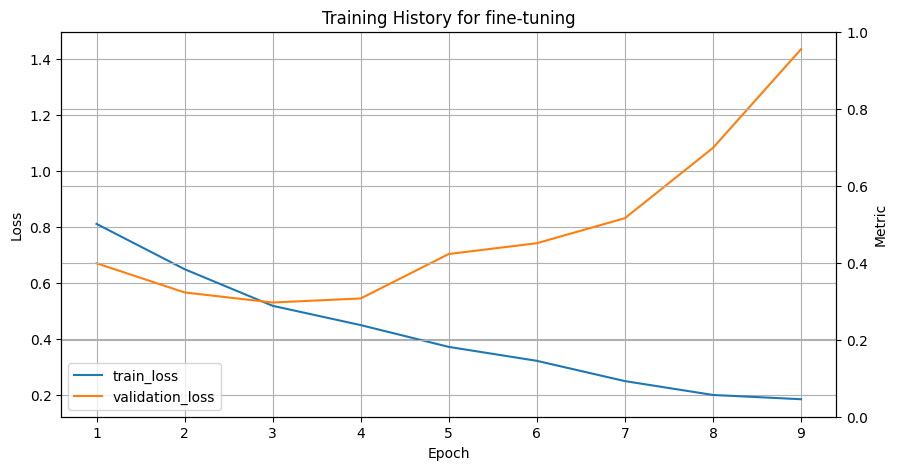

In [16]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

In [17]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
# def load_model(filepath, num_labels=2):
# # Creates a new PT5 model and loads the finetuned weights from a file

#     # load a new model
#     model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=0.4540649581660329, lora_rank=8, lora_init_scale=0.01054546478690803, lora_scaling_rank=3)
    
#     # Load the non-frozen parameters from the saved file
#     non_frozen_params = torch.load(filepath)

#     # Assign the non-frozen parameters to the corresponding parameters of the model
#     for param_name, param in model.named_parameters():
#         if param_name in non_frozen_params:
#             param.data = non_frozen_params[param_name].data

#     return tokenizer, model

# dropout_rate 0.33527687224006164

# lora_rank 16

# lora_init_scale 0.01713843597721974

# lora_scaling_rank 3
def load_model(filepath, num_labels=2):
    # Creates a new ESM model and loads the finetuned weights from a file

    # Load a new model
    model, batch_converter = ESM_classification_model(num_labels=num_labels, dropout=0.33527687224006164, lora_rank=16, lora_init_scale=0.01713843597721974, lora_scaling_rank=3)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return model, batch_converter


In [18]:
# # tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
# tokenizer, model_reload = load_model("model_output/finetuned_model_all_bfd.pth",num_labels=2)

model_reload, batch_converter = load_model("model_output/finetuned_model_all_esm.pth", num_labels=2)


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



In [19]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [ ]:
# model = from_pretrained("model_output")

In [20]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [21]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [22]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [23]:
my_test = my_test_Y

In [24]:
# from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
# from tabulate import tabulate

# # Set the device to use
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model_reload.to(device)

# # create Dataset
# test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# # make compatible with torch DataLoader
# test_set = test_set.with_format("torch", device=device)

# # Create a dataloader for the test dataset
# test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# # Put the model in evaluation mode
# model_reload.eval()

# # Make predictions on the test dataset
# raw_logits = []
# labels = []
# with torch.no_grad():
#     for batch in tqdm(test_dataloader):
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         # add batch results (logits) to predictions
#         raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
#         labels += batch["labels"].tolist()

# # Convert logits to predictions
# raw_logits = np.array(raw_logits)
# predictions = np.argmax(raw_logits, axis=1)

# # Calculate metrics
# conf_matrix = confusion_matrix(labels, predictions)
# tn, fp, fn, tp = conf_matrix.ravel()

# mcc = matthews_corrcoef(labels, predictions)
# specificity = tn / (tn + fp)
# sensitivity = tp / (tp + fn)
# accuracy = accuracy_score(labels, predictions)
# roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


# metrics_table = [
#     ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
#     [mcc, specificity, sensitivity, accuracy, roc_auc]
# ]

# print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
# print(conf_matrix)
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score, accuracy_score
from tabulate import tabulate
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import esm

# Ensure the device is set correctly
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# Function to create dataset for ESM model
def create_dataset(sequences, labels, batch_converter):
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(labels, sequences)))
    dataset = Dataset.from_dict({
        "input_ids": batch_tokens.tolist(),
        "labels": labels
    })
    return dataset

# Assuming my_test is a DataFrame containing test sequences and labels
# Replace uncommon AAs with "X"
my_test["sequence"] = my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)

# Create test dataset
test_set = create_dataset(list(my_test['sequence']), list(my_test['label']), batch_converter)
test_set = test_set.with_format("torch", device=device)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        # add batch results (logits) to predictions
        outputs = model_reload(input_ids)
        logits = outputs.logits.detach().cpu().numpy()
        raw_logits.append(logits)
        labels.extend(batch["labels"].cpu().numpy())

# Convert logits to predictions
raw_logits = np.concatenate(raw_logits, axis=0)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly

metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.599359 |      0.807692 |      0.791667 |        0.8 |  0.873397 |
+----------+---------------+---------------+------------+-----------+
[[21  5]
 [ 5 19]]


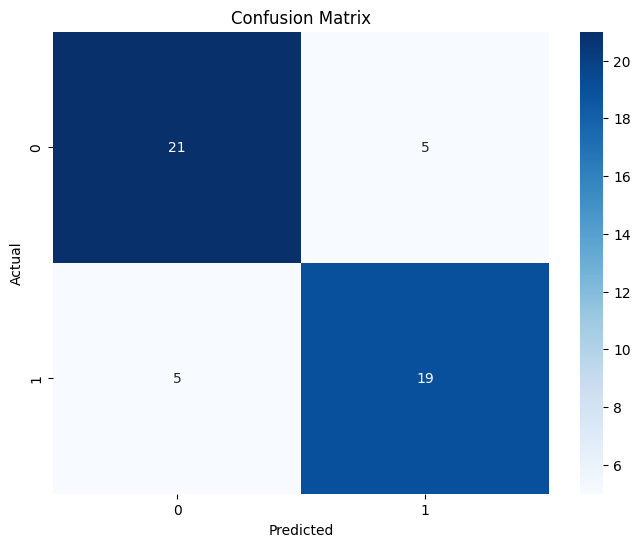

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [27]:
my_test = my_test_ST

In [28]:
# from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
# from tabulate import tabulate

# # Set the device to use
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model_reload.to(device)

# # create Dataset
# test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# # make compatible with torch DataLoader
# test_set = test_set.with_format("torch", device=device)

# # Create a dataloader for the test dataset
# test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# # Put the model in evaluation mode
# model_reload.eval()

# # Make predictions on the test dataset
# raw_logits = []
# labels = []
# with torch.no_grad():
#     for batch in tqdm(test_dataloader):
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         # add batch results (logits) to predictions
#         raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
#         labels += batch["labels"].tolist()

# # Convert logits to predictions
# raw_logits = np.array(raw_logits)
# predictions = np.argmax(raw_logits, axis=1)

# # Calculate metrics
# conf_matrix = confusion_matrix(labels, predictions)
# tn, fp, fn, tp = conf_matrix.ravel()

# mcc = matthews_corrcoef(labels, predictions)
# specificity = tn / (tn + fp)
# sensitivity = tp / (tp + fn)
# accuracy = accuracy_score(labels, predictions)
# roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


# metrics_table = [
#     ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
#     [mcc, specificity, sensitivity, accuracy, roc_auc]
# ]

# print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
# print(conf_matrix)
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score, accuracy_score
from tabulate import tabulate
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import esm

# Ensure the device is set correctly
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# Function to create dataset for ESM model
def create_dataset(sequences, labels, batch_converter):
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(labels, sequences)))
    dataset = Dataset.from_dict({
        "input_ids": batch_tokens.tolist(),
        "labels": labels
    })
    return dataset

# Assuming my_test is a DataFrame containing test sequences and labels
# Replace uncommon AAs with "X"
my_test["sequence"] = my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)

# Create test dataset
test_set = create_dataset(list(my_test['sequence']), list(my_test['label']), batch_converter)
test_set = test_set.with_format("torch", device=device)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        # add batch results (logits) to predictions
        outputs = model_reload(input_ids)
        logits = outputs.logits.detach().cpu().numpy()
        raw_logits.append(logits)
        labels.extend(batch["labels"].cpu().numpy())

# Convert logits to predictions
raw_logits = np.concatenate(raw_logits, axis=0)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly

metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.79it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.529215 |      0.758929 |       0.77027 |   0.764574 |  0.843408 |
+----------+---------------+---------------+------------+-----------+
[[170  54]
 [ 51 171]]


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


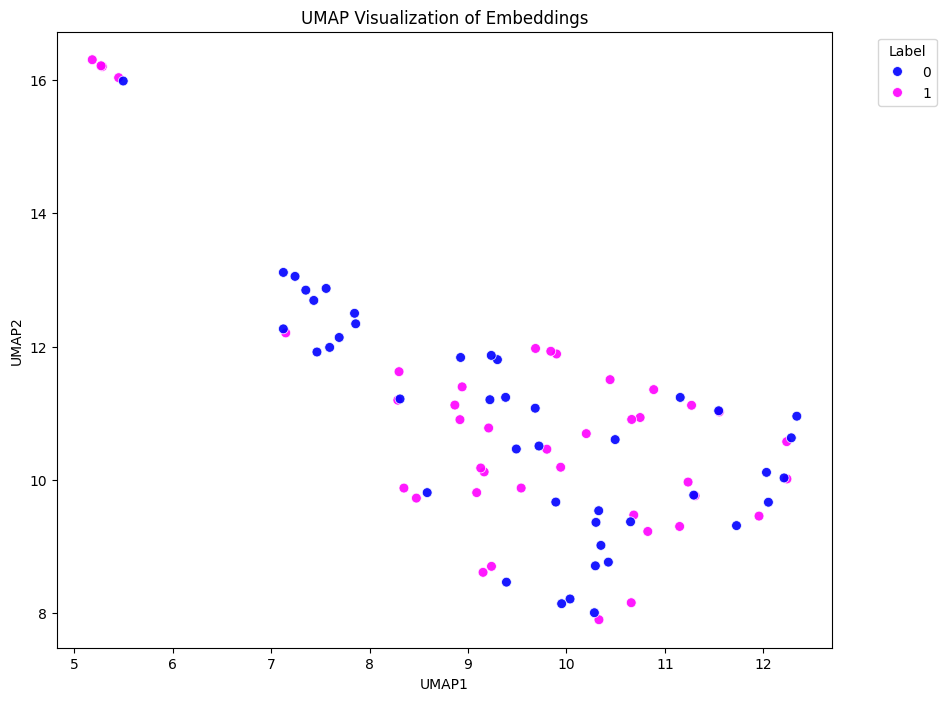

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
